# Introduction

Machine Learning (ML) has recieved lots of attention in the fields of computer vision, artifical intelligence, medicine, and many others. But, with so many different approaches, opinions, and models, it can feel overwhelming when first entering the field. In the earth sciences, we are primarily concerned with discovering how the natural world operates and the forces involved in the shaping it. While ML is a powerful prediction tool, little has been done to implement it as a tool for discovery, especially in the earth sciences. This is primarily due to many of the top performing ML algorithms being difficult to interpret intuitively and even mathematically.

Other problems associated with complex, uninterpretable machine learning models can be manifold. First, troubles arise when we do not know which variables have the most and least influence on the expected outcome. This can become important when making decisions regarding which variables to include and exclude. For instance, if a variable minimally contributes to the predictive power of a model, then we can exclude that variable from the model to form a less complex model. A second problem lies in understanding the functional form of the variables in the machine learning model. This comes into importance if we are interested in how particular variables increase or decrease the expected outcome variable. For example, does an increase in some variable result in a quadratic increase in the outcome? Or an logarithmic decrease? Or a exponential increase?

Fortunately, the field of *Explainable AI (XAI)* concerns itself with exactly what we seek as earth scientists: how are these ML models making predictions and what do they mean about the processes we seek to approximate? In this tutorial, we walk through how to use an interpretable ML model, use a more complex ML model, and apply a post-training explainability technique, specifically using a python package called *SHAP*, to better understand how our ML models are making predictions. 

Another goal of this tutorial is to provide a framework for machine learning on small datasets. When trying to model physical processes we often face the difficulty of accessing large amounts of data due to laborsome collection techniques. This limitation of data becomes a problem when some of the state of the art machine learning algorithms require a large amount of data and find themselves over fitting when provided insufficient amounts of data.
In the tutorial we make use of two models that work well on smaller datasets, specifically the Bayesian Linear Regression and the Guassian Process Regression. We choose these two specific models because, first, both models provide smooth, continuous functions as opposed to step functions provided by tree based models. Second, we can create a baseline model from the Bayesian Linear Regression, with the imbedded assumption that vertical accretion is simply a linear function of the input variables. We can then test to see if a non-paramteric machine learning model, a Gaussian Process Regression, improves any of our performance.


## Scientific Motivation

Sediment is what builds are coastlines. However, the process of sedimentation is incredibly dynamic, constantly being removed, transported, and redeposited. This dynamism makes the prediction of sedimentation rates incredibly difficult. But, since the foundations of our communities are, literally, built upon deposited sediment, it is crucial to know how it works.

Using a comprehensive dataset of coastal marsh sedimentation rates derived from the Coastal Reference Monitoring System (CRMS), we want to discern the driving environmental factors related to sedimentation, as recorded by *vertical accretion rate* (Wagner and Haywood III 2022). Vertical accretion rate in our dataset is recorded as the height of sediment deposited above a datum which is then temporally averaged across 16 years, the total amount of time the CRMS dataset encapsulates. It records the product of the sedimentation processes that build our coastlines and combat land loss. Coastal Louisiana is no stranger to the delicate balance between land loss and sedimentation. Louisiana's sediment budget has been diminshed by upstream damming and the leveeing of the river systems, amplifying land loss caused by relative sealevel rise across the coast. The saying is that coastal Louisiana loses about an american football field worth of land every **hour**! 

Complementing vertical accretion rate measurements, the CRMS dataset provides additional biologic, hydrologic, and sedimentologic variables (TABLE 1) (Wagner and Haywood III 2022). We then augment the dataset by calculating our own Distance to Water, Distance to Rivers, Normalized Difference Vegetation Index (NDVI), and Total Suspended Sediment (TSS) to capture additional environemntal factors that may influence vertical accretion rates. Because marsh sedimentation consists of two parts, an organic and mineral sediment component, there are many potential variables that can contribute to vertical accretion. We want to use a statistical framework to first identify the most salient features, then use a machine learning model to make predictions of vertical accretion rates and understand how environmental variables are able to capture the process of vertical accretion rate.

All the data we use is openly available online with descriptions at:

CRMS: https://www.lacoast.gov/chart/Charting.aspx?laf=crms&tab=2                       
CIMS: https://cims.coastal.louisiana.gov/monitoring-data/ 


## Summary for Easy Access

**Find Intoduction to Descriptive Statistics:** [Link to Data Descriptions](#_DataDescriptions) 

The data descriptions section will give a brief overview of how to visualize and assess the summary statistics of the variables we are trying to model. This sort of general familiarity with our data prior to our machine learning implementation imforms us what we may expect our model to learn and output. 

**Find Example of Exploratory Analysis:** [Link to Exploratory Analysis](#_EDA) 

Exploratory analysis involves becoming accustomed to the relationships exhibited by our data. We use various visualization techniques to achieve this.

**Find Intoduction to Linear Regression Models:** [Link to Explanation of Linear Regression Models](#_linear_regressions) 

Here we briefly discuss how linear regression models approximate unknown functions and make predictions. First, we learn about an ordinary linear regression, followed by a regularized linear regression.

**Find Description of Bayesian Linear Regression:** [Link to Bayesian Linear Regression](#_BLR) 

Since we implement this model for some of our results, we provide a link specifically to the mathematical intuition behind the Bayesian Linear Regression. Here, we primarily focus on how we implement it in our function with sci-kit learn. This is then followed by an example showing that the frequenist and bayesian solution to predictions of $y$ are the same and our implementation of the Bayesian Liena Regression.

**Find Feature Selection: Backward Elimination:** [Link to Feature Selection](#_featureselection)

Here we introduce what feature selection is and two general ways to approach the process. We then implement a backward feature selection algorithm.

**Find Description SHAP explainability package with Bayesian Linear Regression:** [Link to SHAP Introduction and SHAP for Bayesian Linear Regression](#_SHAP) 

An overview of how SHAP works for achieving interpretability from machine learning models. We use the Bayesian Linera Regression to introduce some of the concepts because we already know how to interpret a linear model. 

**Find Description of Gaussian Process Regression:** [Link to Gaussian Process Regression](#_GPR)

A brief overview of the mathematical intuition of the Gaussian Process Regression followed by a simple implementation of a Gaussian Process Regression using sci-kit learn. 

**Find Description of SHAP with Gaussian Process Regression:** [Link to SHAP for Gaussian Process Regression](#_SHAPGPR)

We employ the same SHAP methods introduced on the BLR implementation to the GPR. Some similar and some different relationships between the input variables and the outcome varaible are revealed. 




In [1]:
# import all packages
import pandas as pd 
import numpy as np 
import textwrap 

import seaborn as sns 
import matplotlib.pyplot as plt 

import shap 

from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 

from sklearn.model_selection import KFold, cross_validate, cross_val_predict, RepeatedKFold, cross_val_score, GridSearchCV 
from sklearn.metrics import r2_score, mean_absolute_error 

import statsmodels.api as sm

/Users/etiennechenevert/opt/anaconda3/envs/qwasd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id='_DataDescriptions'></a>
## Brief Data Descriptions

Getting to know our data is crucial. This way we know what processes we are incorporting into our model, which we are excluding, and how many samples we have to capture the full relationship of vertical accretion. 

In [53]:
url = "https://raw.githubusercontent.com/geo-smart/XAI_coastalLA/main/ESIP_dataset4.csv" # Make sure the url is the raw version of the file on GitHub
df = pd.read_csv(url)
print(df.columns) # lets see what variables we are working with

Index(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)',
       'Average Height Dominant (cm)', 'NDVI', 'TSS (mg/l)', 'Windspeed (m/s)',
       'Avg. Time Flooded (%)', 'Flood Freq (Floods/yr)',
       'Log Distance to Water (km)', 'Log Distance to River (km)', 'Community',
       'Latitude', 'Longitude', 'Organic Matter (%)', 'Bulk Density (g/cm3)',
       'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)',
       '10th Percentile Flood Depth (cm)', 'Avg. Flood Depth (cm)',
       'Std. Deviation Flood Depth (cm)'],
      dtype='object')


In [3]:
# lets know how many variables and how many samples we have to work with
print("Number of samples in dataset: ", len(df))
print("Number of features in the dataset: ", len(df.columns))

Number of samples in dataset:  266
Number of features in the dataset:  21


In [4]:
# There are some unnecessary and/or uninformative variables in here, so lets remove them
df = df.drop([
    'Longitude', 'Latitude', 'Bulk Density (g/cm3)', 'Organic Matter (%)'
], axis=1)

I removed the variables longitude, latitude, bulk density (g/cm3), and organic matter (%) because they do not provide us with an associated transport mechanism or biologic process such as flooding, biomass production, biomass decay, erosion, etc. Latitude and longitude are only geographic descriptions of where sites are, making them uninformative towards a process understanding of vertical accretion. While bulk density and organic matter (%) are descriptions of the soil that has already been deposited, rather than *how* it might have been deposited.

In [5]:
outcome = 'Accretion Rate (mm/yr)'
feature_ls = list(df.columns.values[1:-1]) # make a list including all the variables; 
                                           # excluding the categorical Site and Maarsh community variables
print(feature_ls)

['Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)', 'Average Height Dominant (cm)', 'NDVI', 'TSS (mg/l)', 'Windspeed (m/s)', 'Avg. Time Flooded (%)', 'Flood Freq (Floods/yr)', 'Log Distance to Water (km)', 'Log Distance to River (km)', 'Community', 'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)', '10th Percentile Flood Depth (cm)', 'Avg. Flood Depth (cm)']


## Variable Descriptions

The remaining variables that will be used in the analysis are: 
* **Accretion Rate (mm/yr)**: The amount of sediment deposited above a datum. Recorded with a 6 to 18 month sampling interval.
* **Soil Porewater Salinity (ppt)**: The ppt measured from a syringe inserted into the soil. Recorded variably to annually.
* **Average Height Dominant (cm)**: Survey measurement of the average hieght of the dominant vegetation species. Sampled annually. 
* **NDVI**: The Normalized Difference Vegetation Index which is an estimate of aboveground biomass from Landsat 7. Samples consisted of an 8 day averages only collected during the months of peak biomass, July-August.
* **TSS (mg/l)**: Estimate of Total Suspended Sediment (TSS) from MODIS. With a 2-day sampling (recurrance) interval.
* **Windspeed**: Reanalysis data from the Global Wind Atlas available from Google Earth Engine (GEE) (The Global Wind Atlas 3 2022).
* **Tidal Amplitude (cm)**: The average daily difference between the highest recorded and lowest hourly waterlevel as recorded from an underwater sonde.
* **Average Time Flooded (%)**: The percentage of time in which the waterlevel exceeds the elevaation of the marsh. Calculated from hourly waterlevel measurements from an underwater sonde.
* **Flood Frequency (Floods/yr)**: The number of times that the waterlevel exceeds the elevation of the marsh. Calculated from hourly waterlevel measurements from an underwater sonde.
* **Average Flood Depth (cm)**: The average waterlevel when the waterlevel is higher than the marsh elevation. Calcualted from hourly waterlevel measurements from an underwater sonde. 
* **90th Percentile Flood Depth (cm)**: The 90th percentile of the timeseries distribution of average flood depth. Calculated from hourly waterlevel measurements from an underwater sonde.
* **10th Percentile Flood Depth (cm)**: The 10th percentile of the timeseries distribution of average flood depth. Calculated from hourly waterlevel measurements from an underwater sonde.
* **Std. Deviation Flood Depth (cm)**: The standard deviation of the timeseries distribution of average flood depth. Calculated from hourly waterlevel measurements from an underwater sonde. 
* **Log Distance to Water (km)**: The log of the distance to the nearest water pixel (90% recurrence). 
* **Log Distance to River (km)**: The log of the distance to the nearest Global River Width from Landsat (GRWL) dataset river vectors taken from GEE (Allen and Pavelsky 2018). 
* **Community**: Marsh Community (Freshwater, Intermediate, Brackish, Saline, Swamp) determined from surveys of                        vegetation and salinity gradients.

Note that all of these variables spanned either the lifespan of a CRMS site which largely encapsulates 2007 to 2022 (Wagner and Haywood III 2022). 

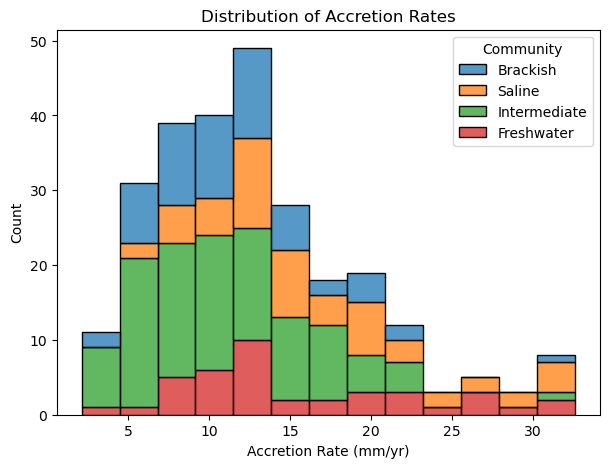

In [6]:
# Let's visualize what we want to predict, 'Accretion Rate (mm/yr)'
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(1, 1, 1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="Accretion Rate (mm/yr)", kde=False,
             hue="Community",
             element="bars", legend=True)
ax.set_title("Distribution of Accretion Rates")
ax.set_xlabel("Accretion Rate (mm/yr)")
ax.set_ylabel("Count")
plt.show()

In [7]:
# Let's define our target and design matrix for our ML job
target = df[outcome]
phi = df.drop(['Unnamed: 0', 'Accretion Rate (mm/yr)', 'Community'], axis=1)

In [8]:
# Let's get a picture of the target variable, vertical accretion
target.describe()

count    266.000000
mean      13.093916
std        6.449721
min        2.128280
25%        8.226964
50%       12.174938
75%       16.227400
max       32.589286
Name: Accretion Rate (mm/yr), dtype: float64

In [9]:
# Some decriptive statistics to get a picture of the distributions
phi.describe()

,Soil Porewater Salinity (ppt),Average Height Dominant (cm),NDVI,TSS (mg/l),Windspeed (m/s),Avg. Time Flooded (%),Flood Freq (Floods/yr),Log Distance to Water (km),Log Distance to River (km),Tidal Amplitude (cm),90th Percentile Flood Depth (cm),10th Percentile Flood Depth (cm),Avg. Flood Depth (cm),Std. Deviation Flood Depth (cm)
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,7.186861,112.439643,0.353358,31.821080,6.683651,39.207975,261.107686,0.342556,3.026571,9.283287,24.836617,0.314712,9.731371,11.897189
std,6.039870,28.938786,0.110811,13.033298,0.272169,28.512498,549.612559,1.077911,1.004707,9.204314,9.858570,1.560128,5.785805,3.026577
min,0.100000,54.860000,0.057249,0.000000,5.864558,0.000000,0.000000,-3.534766,-1.828729,0.060442,0.914400,0.000000,1.173515,4.595155
25%,2.425000,97.000000,0.292554,28.556742,6.525110,15.867526,51.426390,-0.110944,2.519015,0.312294,18.267426,0.000000,5.835615,10.014167
50%,5.600000,108.300000,0.364691,32.970487,6.703245,39.127680,161.037234,0.268765,3.257276,6.584424,24.292560,0.000000,8.483845,11.656643
75%,10.300000,122.100000,0.399708,39.331860,6.872427,59.170743,250.736063,1.187492,3.814583,18.043368,29.794200,0.000000,12.263635,13.760751
max,27.500000,315.800000,0.627081,65.011248,7.315856,99.999999,4693.096330,2.504450,4.314392,27.500165,65.257680,18.592800,41.731574,24.649485


<a id='_EDA'></a>
# Exploring the Data

To get a better feel for the potential relationships present in our data set, let's plot some things! It is always good to know what relatinships our machine learning models might capture and which variables may be more significant than others.

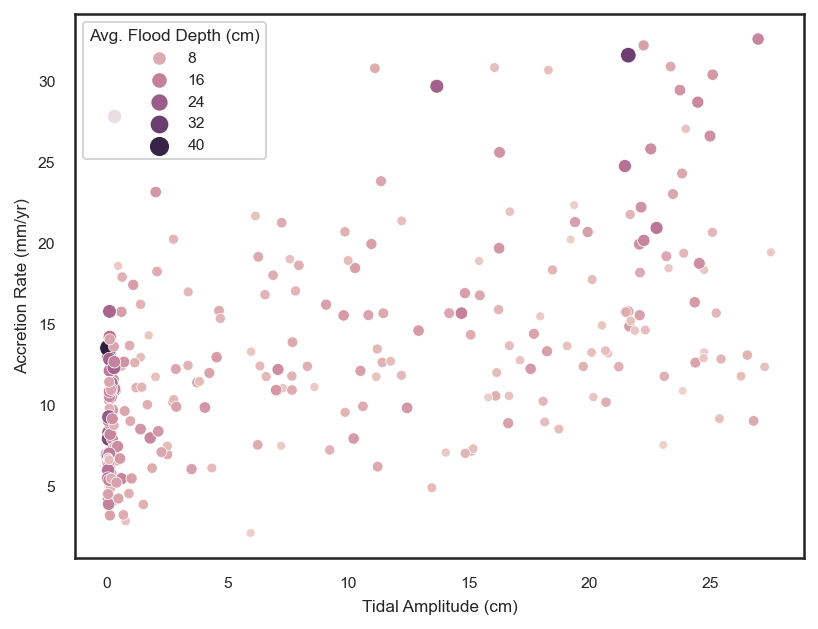

In [57]:
# scatter plots and histograms of tide amp and flood depths to explain the data before fitting
sns.scatterplot(data=df, y='Accretion Rate (mm/yr)', x='Tidal Amplitude (cm)', hue='Avg. Flood Depth (cm)',
               size='Avg. Flood Depth (cm)')
plt.show()

Tidal amplitude records the average daily difference between the highest and lowest waterlevel recorded at CRMS station. While this may give us an idea of the depth of flooding tidal waters, it is more related to the position of the site within the tidal frame. The position of a station within a tidal frame is a summary variable that is related to many different aspects of the marsh ecosystem, including vegetation type, organic production, and modes of sedimentation. 

The scatter plot above shows us how tidal amplitude varies with accretion rate, where we can see a linear increase in accretion with respect to tidal amplitude. Notice that the points are colored by the average recorded flood depth of each site and that the highest average flood depth are actually higher in the tidal frame (lower tidal amplitude) with the exception of only a few. 

To further investigate this intruiging correlation beween the flood depth, tidal amplitude, and accretion rate, let's investigate another similar scatter plot

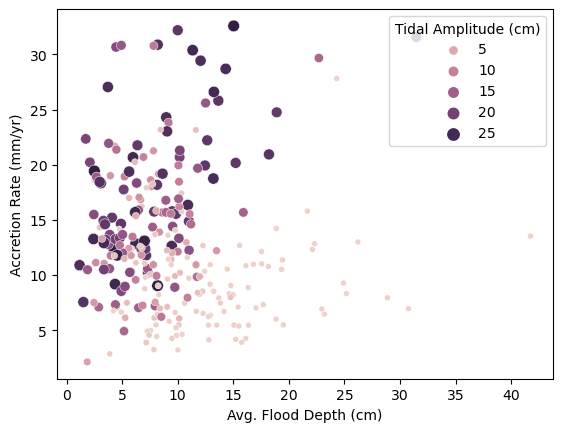

In [14]:
sns.scatterplot(data=df, y='Accretion Rate (mm/yr)', x='Avg. Flood Depth (cm)', hue='Tidal Amplitude (cm)',
               size='Tidal Amplitude (cm)')
plt.show()

By visualizing the relationship between average flood depth and accretion rate, colored by tidal amplitude, we can see that CRMS stations with high tidal amplitudes exhibit a stronger positive relationship between flood depth and accretion rate than stations with smaller tidal amplitudes. 

Now let us investigate how accretion, tidal amplitude, and the soil porewater salinity vary together to get an idea of where and how sediment is being deposited within the tidal frame. We are investigating the soil porewater salinity term now because it will give us an idea about the hydrologic inputs into the marsh, less salinity indicates a fresh water hydrologic regime while high levels of salinity indicates a hydrologic regime closer to the ocean.

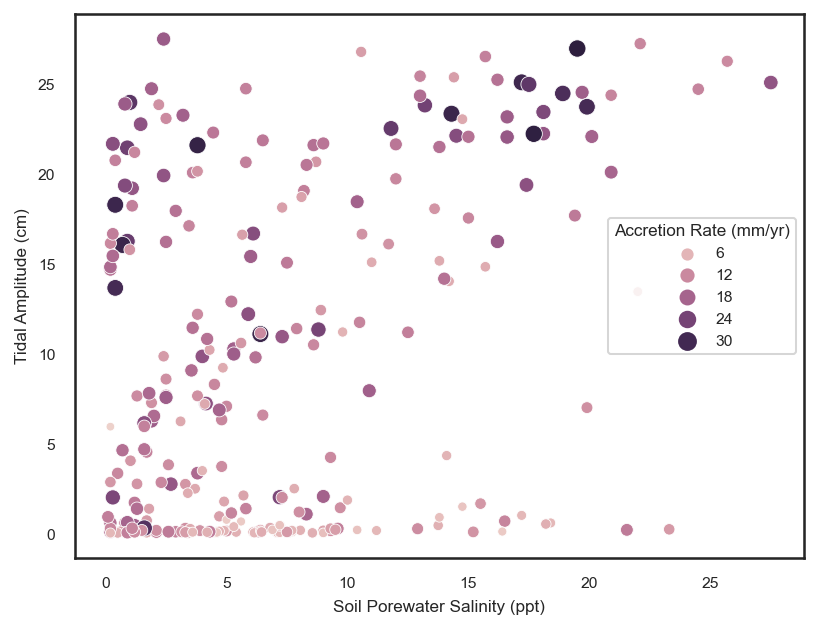

In [58]:
sns.scatterplot(data=df, y='Tidal Amplitude (cm)', x='Soil Porewater Salinity (ppt)', hue='Accretion Rate (mm/yr)',
               size='Accretion Rate (mm/yr)')
plt.show()

Here we can discern the idea that there are two local hotspots for sedimentation occurring high in the tidal frame, one in the upper left of the plot and in the upper right. What could be the determining factors of these sedimentation hotspots?

Let us take a look at which marsh communities these hotspots occur in.

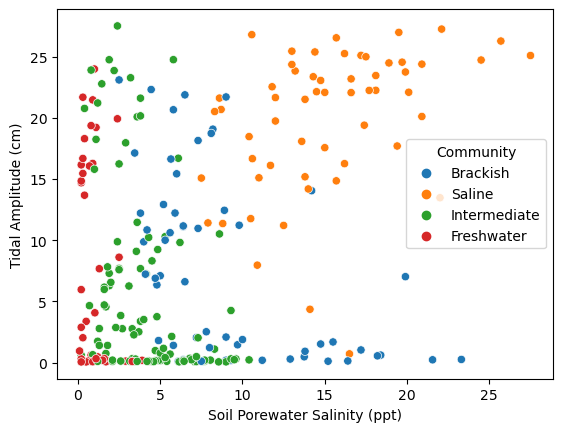

In [16]:
sns.scatterplot(data=df, y='Tidal Amplitude (cm)', x='Soil Porewater Salinity (ppt)', hue='Community')
plt.show()

Okay, so the sedimentation hotspots occur in the freshwater and intermediate marshes (upper left) and the saline marshes (upper right). One hypothesis for why these two distinct hotspot occur could be that there are two distinct modes of sediment transport here: from riverine flooding and from oceanic, storm and wave driven flooding. The riverine flooding is a likely culprit for introducing sediment into the freshwater marshes, while the ocean influenced flooding is the likely culprit in the marshes disconnected from rivers. Let us keep this in mind when we test our nonlinear Gaussian Process regression.

# Interpretable Models

Every machine learning model is interpretable in some way or another, however, simpler models are much easier to interpret. Many top performing models, such as Artifical Neural Networks, Convolutional Neural Networks, and ensemble tree based models are not readily interpretable. Their lack of interpretability can discourage scientists from using them, which limits the tool set of a scientific investigator. But, there are also less popular but equally well performing models that are interpretable out there. We will discuss two types of models, a Bayesian Linear Regression and a Gaussian Process Regression, that both have analytical solutions for the conditional probability of our target variable. 

<a id='_linear_regressions'></a>
## Linear Regression

First, let's start with how a linear regression operates. 

A linear regression is one of the most interpretable machine learning models to implement. The approach to approximate an unknown function, $f(x)$, using a linear regression assumes that $f(x)$ is a linear combination of the input features, $X$, such that
$$f(x,w)= \sum^N_{i=1} w_i x_i $$
Equation 1

where $w$ is the unknown parameter known as the weight vector, $N$ is the number of predictors, and $x$ are the input features. A more familiar writing of the above equation can look like: 
$$ y=w_0+w_1 x_1+⋯+w_N x_N $$
Equation 2

This is called a parametric machine learning model because we assume the form of the function we are trying to approximate, a linear form. The one parameter an ordinary linear model needs to learn is the weight vector $w$. This vector determines the influence of each of the input predictors, in our case environmental variables, that influence the target, vertical accretion. To solve for the optimal weight vector, we need to take the most likely set of maximum likelihood of the target $y$ given a linear combination of $w X$. To do this, we first write the likelihood function generally

$$p(y | X, w, \beta) = \prod \mathcal{N}(y_n | w^T x_n , \beta^-{1})$$
Equation 3

Where $\beta$ is the noise associated with the target. Now, given our training data we want to find the $w$ parameter that maximizes this equation, the likelihood of $y$. To do this, we need to take teh logarithm of the equation, then the derivative, then set the equation to zero, and solve for $w$.

Then solving for $w$ we get

$$w = (X^T X)^{-1} X^T y$$
Equation 4

This is the learned optimal set of the weight vector and is obtained from the Gauss-Markov Theorem.


## Regularized Linear Regression

Both a classic linear regression and a Bayesian linear regression can be modified to mitigate the effects of overfitting to the training data. Overfitting is when our model places undue importance to certain features, commonly occurring when given many input features. The effect is that we perfectly fit to our training data, making our model perform poorly when given new data. A visualization of this is given below.

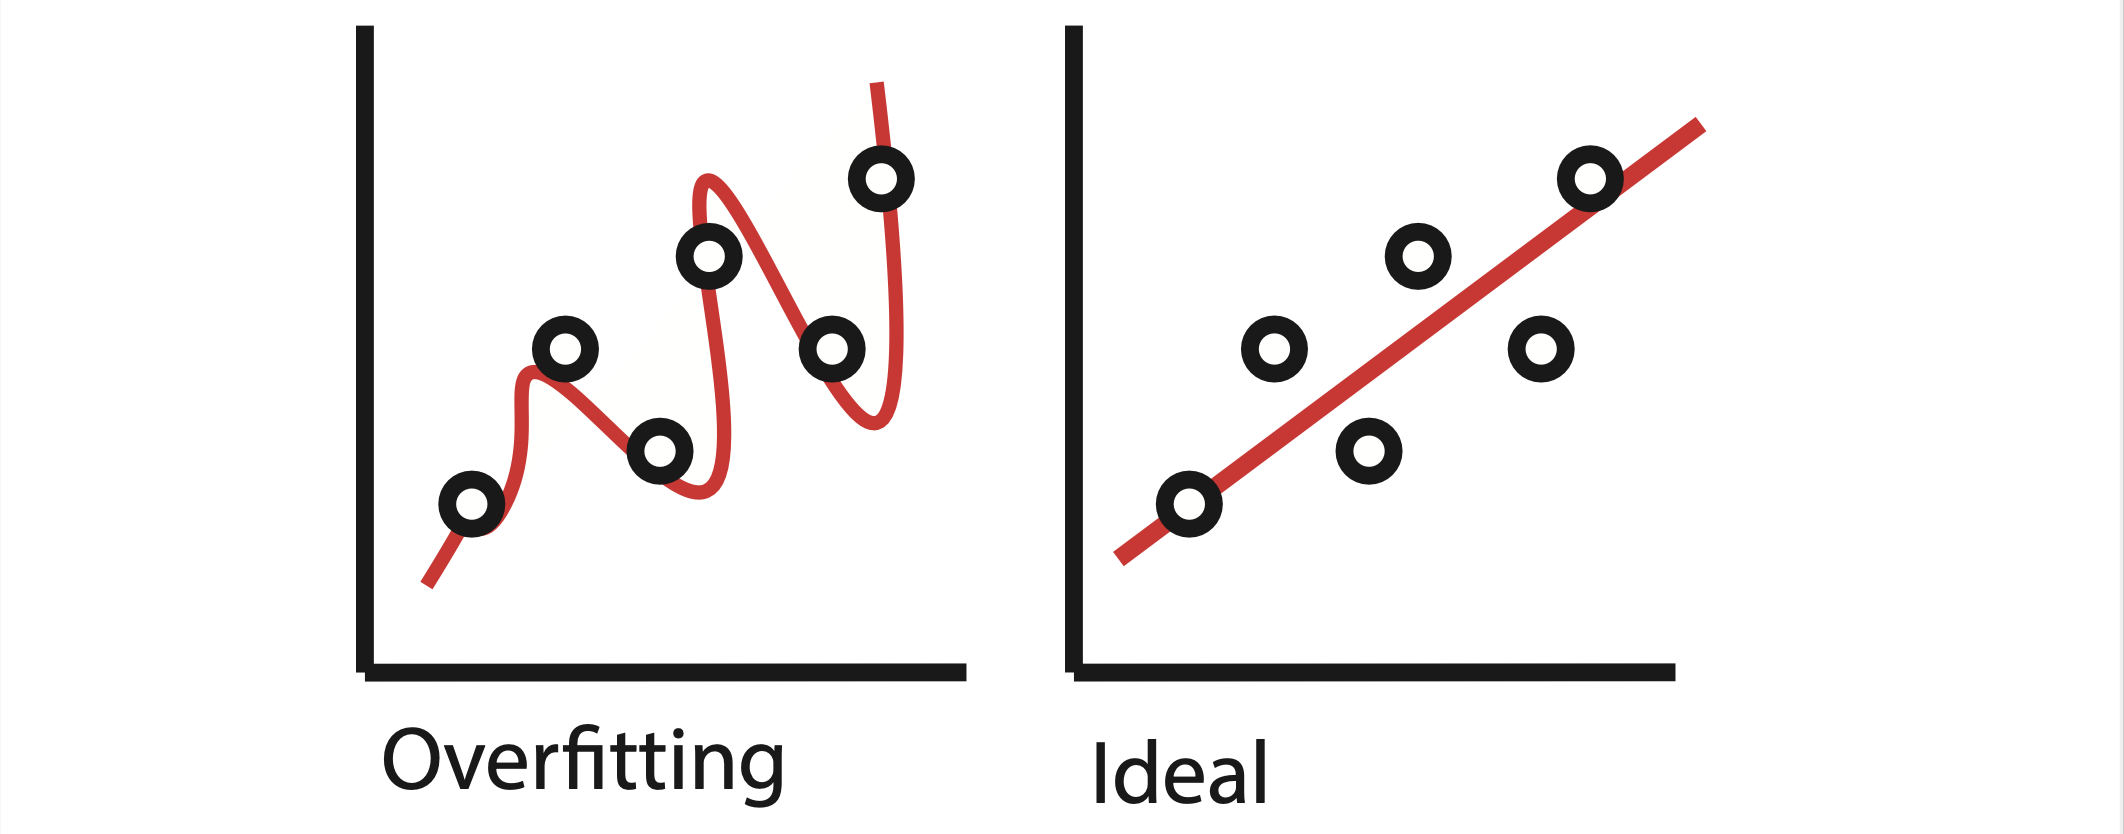

To combat overfitting, a regularization term is employed. The term can either be an L1 or L2 regularization term and it is subsequently added to the sum of squares error equation $\sum_{i=1}^{N} (y_i - w^T x_i)^2$, such that the new total error equation becomes either

L1 regularized sum of square errors:
$$ \sum_{i=1}^{N} (y_i - w^T x_i)^2 + \frac{\lambda}{2}|w| $$
Equation 5

L2 regularized sum of square errors:
$$ \sum_{i=1}^{N} (y_i - w^T x_i)^2 + \frac{\lambda}{2} w^T w $$
Equation 6

As we can see, $\lambda$ is an important term determining how much to penalize large weight coefficents. In a frequenist framework this term has to be defined explicitly by the investigator or through a cross validation technique that tests various possible values for $\lambda$ and selects the value which minimizes testing error. Cross validation is a machine learning model evaluation method in which a dataset is split into $K$ folds, then the model is trained on $K-1$ folds, then tested on the remaining one fold where some error metric is computed. This is then repeated $K$ times, alternating the fold in which we test on, and the calculated model errors are then averaged. A schematic is shown below

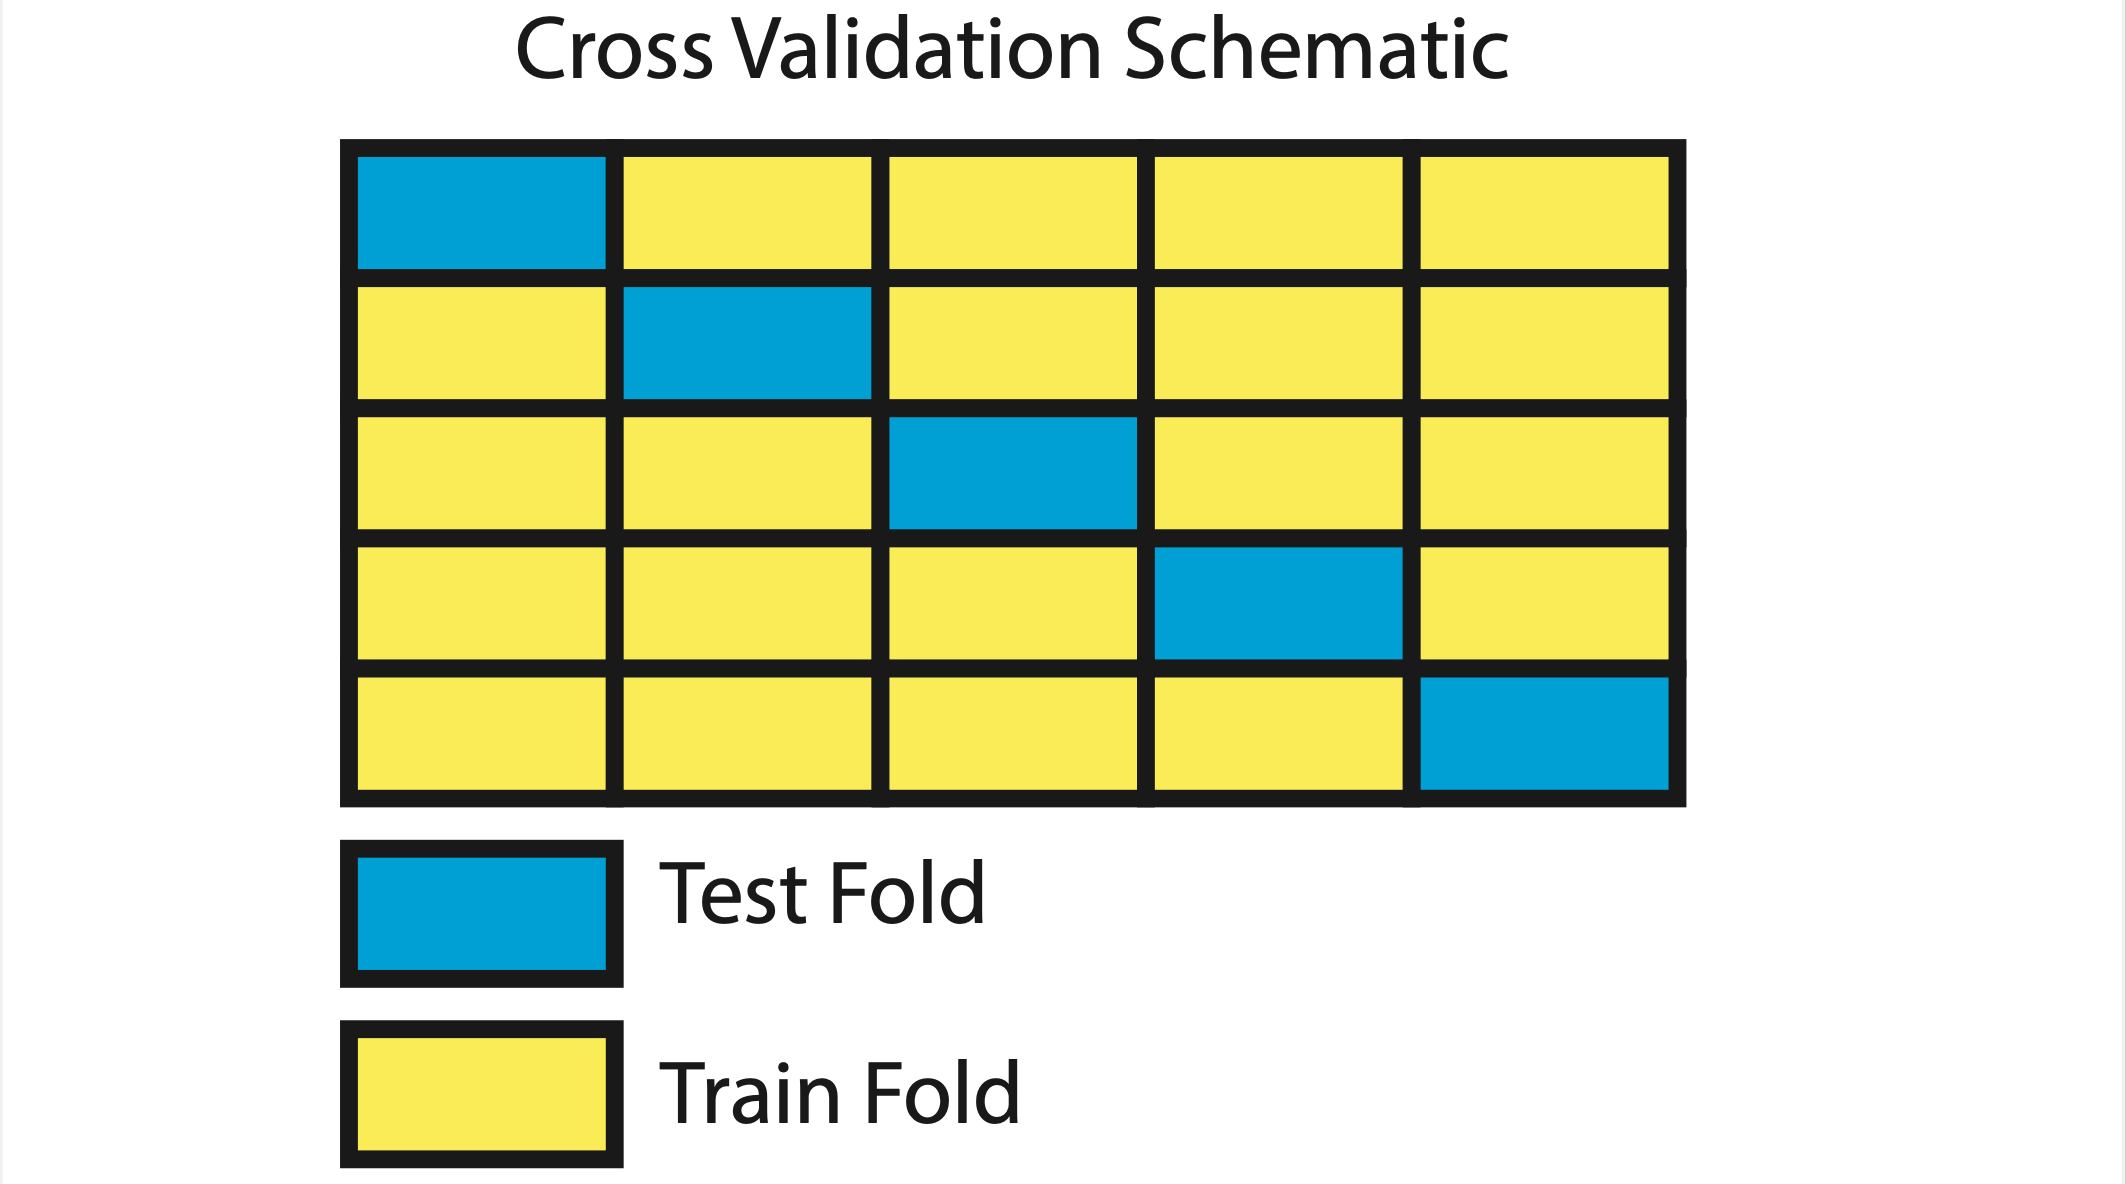

When a proper $\lambda$ value is found, we then apply the same process for the solution of the best weight vector as we did for the ordinary linear regression to get:

$$w = (\lambda I + X^T X)^{-1} X^T y$$
Equation 7

This then becomes the optimal weight vector for a regularized linear regression.


<a id='_BLR'></a>
## Bayesian Linear Regression (BLR) 

A Bayesian linear regression is simply a reformulation of the classic, Frequenist linear regression explained above from a Bayesian perspective. The only difference is that the Bayesian perspective deals with probabilities in the form of distributions rather than point estimations. Therefore, both the Frequenist and Bayesian treatment of linear regression have the same tractable solution to the conditional probability of our target variable (Bishop 2006). This is preferable from a scientific perspective when making conclusions from the learned weight parameters and building confidence in our model’s predictions. 

To find the weight vector from a Bayesian perspective we take the log derivative of the posterior distribution of $w$, which is the product of the prior and the likelihood functions over $w$. The log of the posterior follows similarly to the regularized sum of square errors equations (Bishop 2006). 
$$ \ln p(w|X, y) = -\frac{\beta}{2} \sum_{i=1}^N(y_i - w^T x_i)^2 - \frac{\alpha}{2} w^T w $$ 
Equation 8

Where $\beta$ is the noise parameter over y, the target variable from the train set, and $\alpha$ is the precision, or noise, over the weight parameter. $X$ is the data in the design matrix. We then maximize the log posterior with respect to $w$ by taking the derivative, setting to zero, and solving for $w$ to find the most likely $w$ vector. 

From further inspection of the equation, we see that $\alpha / \beta$ act the same as $\lambda$ in the L2 regularized solution. This is where an advantage of the Bayesian treatment arises because all we need to do is find the values for $\alpha$ and $\beta$ to get the regularization parameter $\lambda$. This can be done through a technique called *Empirical Bayes* with an iterative algorithm. Another advantage of the Bayesian treatment is that, by dealing with distributions, model uncertainty quantification can be readily attained through the standard deviation of the predictive distribution and from the eigen decomposition of matrix of feature inputs (Bishop 2006, MacKay 1992).

## Scaling Features

It is important to scale our features due to potential biases influencing the relative influences of features due to the varying numerical values of the features. For instance, for two features of the same influence in a linear regression, if a feature contains very low values, then the learned weight coefficent for that feature will be notably larger than the other feature with larger values. This is due to having to multiply the smaller vector by a larger weight to achieve the same output as the larger feature vector. Note that both the Baysian Linera Regression and the Gaussian Process Regression have this scaling requirement. 

In [10]:
# Scale variables to minimize bias between features
scalar = StandardScaler()
data = pd.DataFrame(scalar.fit_transform(phi), columns=phi.columns.values)

## Bayesian and Frequenist Linear Regression have the same solution

Just to solidfy the notion that the both an L2 regularized linear regression for a Bayeisan and Frequenist persepctive have the same solution, we are going to implement both types of L2 linear regression using scikit learn. In scikit learn's library, the Ridge regression is the frequensit L2 regularized linear regression and the Bayesian Ridge regression is the Bayesian L2 regularized linear regression. In the below cells we will implement meant them both.

In [54]:
# Testing whether the scikit learn ridge and bayesian ridge learn the same paramters
olsr = linear_model.Ridge()
br = linear_model.BayesianRidge()

# We need to hyperparamter tune the OLS Ridge because there is no way to solve for the regularization parameter analytically
searcher = GridSearchCV(olsr, {'alpha': np.arange(1, 300, 2)}, scoring="neg_root_mean_squared_error")
searcher.fit(data[['Tidal Amplitude (cm)', 'Avg. Flood Depth (cm)']], target)
best_olsr = searcher.best_estimator_
print("Best regularizor by Cross Validation: ", searcher.best_params_)
print("Learned Weight Coefficents: ", best_olsr.coef_)

Best regularizor by Cross Validation:  {'alpha': 1}
Learned Weight Coefficents:  [3.90306258 1.13199355]


In [55]:
# fit the br and see if it is the same
br.fit(data[['Tidal Amplitude (cm)', 'Avg. Flood Depth (cm)']], target)
print("Learned Regularizor: ", br.lambda_ / br.alpha_)
print("Learned Weight Coefficent: ", br.coef_)

Learned Regularizor:  3.433346530743498
Learned Weight Coefficent:  [3.8591872  1.10676778]


From the weight coefficents and learned regularizors, we can see that the two methods produce similar results. While the only difference arises from the learned regularization term. We are able to find the Bayesian Ridge Regression solves for a higher regularization term of 3.44 through the Empirical Bayes method, while the cross-validation of the OLS Ridge Regression finds an optimal regularization term value of 1. 

# Bayesian Ridge Regression Implementation

We decide to utilize a Bayesian Ridge, L2 regularization, regression in this tutorial. In my implementation of Bayesian Ridge Regression model, I explicitly conduct repeated cross validation by randomly splitting my dataset into K-folds and iterating this process 100 times through a loop. I do this in order to extract the learned parameters and predictions of each of the 500 models (5 fold splits repeated 100 times) and plot them in the subsequent graphs. 

However, I need to first make a function that unstandardizes the weight coefficents so they interpretable in the usual way of "a 1 unit increase in X results in a value-of-weight-coefficent increase in y."

In [59]:
def unscaled_weights_from_Xstandardized(X, bayesianReg: linear_model):
    """
    This code only works for Bayesian Ridge Regression. We rescale the weights using a rearrangement of the 
    scaled linear regression equation.
    X: dataframe
    bayesianReg: linear model from scikit learn
    Helpful source:
    https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables
    """
    a = bayesianReg.coef_
    i = bayesianReg.intercept_
    # Me tryna do my own thing
    coefs_new = []
    for x in range(len(X.columns)):
        # print(X.columns.values[x])
        col = X.columns.values[x]
        coefs_new.append((a[x] / (np.asarray(X.std()[col]))))
    intercept = i - np.sum(np.multiply(np.asarray(coefs_new), np.asarray(X.mean()/X.std())))  # hadamard product

    return coefs_new, intercept

Now, because linear regression models are prone to overfitting the data we need to select only the essential variables for predicting our outcome, vertical accretion rate. Overfitting the data occurs when our model ends up finding a function that aproximates our training data too much, so that when given new data it performs poorly.

<a id='_featureselection'></a>
The process of finding only the necessary variables for our model is called ***feature selection*** and there are two ways to proceed through it. Option one is to simply apply our domain knowledge on the subject we want to approximate, sedimentation on marsh environments. In this methodology, we will consult our previous knowledge on how sedimentation occurs in these environments and include every variable we deem necessary to model accretion rates. However, this approach is not always feasible for highly complex relationships or for situations where we do not have sufficient domain knowledge on our outcome variable. Option two applies an unbiased, reproducible methodology based on some metric. A popular choice for this approach is to use an algorithm called *backward feature selection.* In the algorithm, we fit a multivariate linear regression to our outcome variable using all of our data, then compute the p-value for each variable. We then iteratively drop the variable with the highest p-value until every variables has a p-value below a given threshold, generally 0.05. 

We are going to use the backward elimination approach to feature selection because marsh vertical accretion rates can depend on many different environemntal variables due these environemnts being at the confluence on land, rivers, and ocean. Therefore, we want to reduce the complexity of our linear regression for vertical accretion by only selecting statistically significant variables related to it. 

Below is our implementation of backward elimination.

In [18]:
def backward_elimination(data, target, num_feats=10, significance_threshold=0.05):
    """
    data: dataframe of predictors
    target: dataframe of target variable
    num_feats: maximum number of features to be included in the return list
    significance_threshold: threshold p-value that determines significance and elimination
    
    returns: list of significant variables
    
    Code is adapted from: 
    https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/#:~:text=1.-,Forward%20selection,with%20all%20other%20remaining%20features.
    """
    features = data.columns.tolist()
    target = list(target)
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_threshold) or (len(features) > num_feats):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

# Obtain a list of the significant variables
bestfeatures = backward_elimination(data=data, target=target, num_feats=10, significance_threshold=0.05)
print(bestfeatures)

['Soil Porewater Salinity (ppt)', 'NDVI', 'TSS (mg/l)', 'Windspeed (m/s)', 'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)']


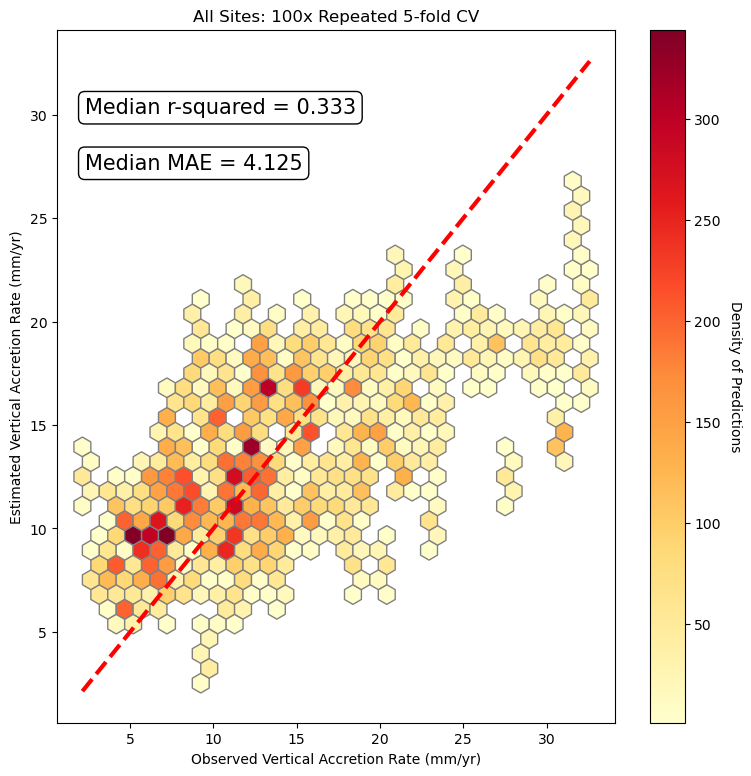

['Scaled Weights', 'Unscaled Weights', 'Scaled regularizors', 'Predictions']


In [19]:
# Plotting and parameter retrieval function for Ridge and BLR Ridge
def cv_results_and_plot(baymod, unscaled_predictor_matrix, predictor_matrix, target, color_scheme: dict):
    features = list(predictor_matrix.columns)
    # Error Containers
    predicted = []  # holds they predicted values of y
    y_ls = []  # holds the true values of y

    hold_weights = {}  # container that holds the learned weight vectors
    hold_unscaled_weights = {}  # container that holds the inverted learned weight vectors
    hold_regularizors = {}  # container that holds the learned regularization constant
    hold_predicted = {}

    # Performance Metric Containers: I allow use the median because I want to be more robust to outliers
    r2_total_medians = []  # holds the k-fold median r^2 value. Will be length of 100 due to 100 repeats
    mae_total_medians = [] # holds the k-fold median Mean Absolute Error (MAE) value. Will be length of 100 due to 100 repeats

    # parameter holders
    weight_vector_ls = []  # holds the learned parameters for each k-fold test
    regularizor_ls = []  # holds the learned L2 regularization term for each k-fold test
    unscaled_w_ls = [] # holds the inverted weights to their natural scales
    prediction_list = []

    for i in range(100):  # for 100 repeats
        try_cv = KFold(n_splits=5, shuffle=True)
        results_for_3fold = cross_validate(baymod, predictor_matrix, target.values.ravel(), cv=try_cv,
                                           scoring=('r2', 'neg_mean_absolute_error'),
                                           n_jobs=-1, return_estimator=True)
        # Scaled lists
        r2_ls = []
        mae_ls = []
        # Inversed lists
        r2_inv_ls = []
        mae_inv_ls = []
        # Certainty lists
        pred_list = []

        for train_index, test_index in try_cv.split(predictor_matrix):
            X_train, X_test = predictor_matrix.iloc[train_index], predictor_matrix.iloc[test_index]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]
            # Fit the model
            baymod.fit(X_train, y_train.values.ravel())
            # collect unscaled parameters
            unscaled_weights, intercept = unscaled_weights_from_Xstandardized(unscaled_predictor_matrix[features],
                                                                              baymod)
            unscaled_w_ls.append(unscaled_weights)

            # Collect scaled parameters
            weights = baymod.coef_
            weight_vector_ls.append(abs(weights))  # Take the absolute values of weights for relative feature importance
            regularizor = baymod.lambda_ / baymod.alpha_
            regularizor_ls.append(regularizor)
            design_m = np.asarray(X_train)
            eigs = np.linalg.eigh(baymod.lambda_ * (design_m.T @ design_m))

            # Make our predictions for y
            ypred = baymod.predict(X_test)
            pred_list += list(ypred)

            # Metrics for scaled y: particularly for MAE
            r2 = r2_score(y_test, ypred)
            r2_ls.append(r2)
            mae = mean_absolute_error(y_test, ypred)
            mae_ls.append(mae)
            # Metrics for inversed y: particularly for MAE
            r2_inv = r2_score(y_test, ypred)
            r2_inv_ls.append(r2_inv)
            mae_inv = mean_absolute_error(y_test, ypred)
            mae_inv_ls.append(mae_inv)

        # Average certainty in predictions
        prediction_list.append(pred_list)

        # Average predictions over the Kfold first: scaled
        r2_median = np.median(r2_ls)
        r2_total_medians.append(r2_median)
        mae_median = np.median(mae_ls)
        mae_total_medians.append(mae_median)

        predicted = predicted + list(cross_val_predict(baymod, predictor_matrix, target.values.ravel(), cv=try_cv))
        y_ls += list(target.values.ravel())

    # Add each of the model parameters to a dictionary
    weight_df = pd.DataFrame(weight_vector_ls, columns=features)
    unscaled_weight_df = pd.DataFrame(unscaled_w_ls, columns=features)
    
    # Now calculate the mean of th kfold means for each repeat: scaled accretion
    r2_final_median = np.median(r2_total_medians)
    mae_final_median = np.median(mae_total_medians)
    
    # Below code is for the figure
    fig, ax = plt.subplots(figsize=(9, 9))
    hb = ax.hexbin(x=y_ls,
                   y=predicted,
                   gridsize=30, edgecolors='grey',
                   cmap=color_scheme['cmap'], mincnt=1)
    ax.set_facecolor('white')
    ax.set_xlabel("Observed Vertical Accretion Rate (mm/yr)")
    ax.set_ylabel("Estimated Vertical Accretion Rate (mm/yr)")
    ax.set_title("All Sites: 100x Repeated 5-fold CV")
    cb = fig.colorbar(hb, ax=ax)
    cb.ax.get_yaxis().labelpad = 15
    cb.set_label('Density of Predictions', rotation=270)
    ax.plot([target.min(), target.max()], [target.min(), target.max()],
        color_scheme['line'], lw=3)

    ax.annotate("Median r-squared = {:.3f}".format(r2_final_median), xy=(20, 450), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    ax.annotate("Median MAE = {:.3f}".format(mae_final_median), xy=(20, 410), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    plt.show()
    
    return {
        "Scaled Weights": weight_df, 
        "Unscaled Weights": unscaled_weight_df, 
        "Scaled regularizors": regularizor_ls, 
        "Predictions": prediction_list, 
    }


results_dict = cv_results_and_plot(br, phi, data[bestfeatures], target, {'cmap': 'YlOrRd', 'line': 'r--'})
# lets look at the keys of the returned results dictionary for future reference
print(list(results_dict.keys()))

Using the significant variables, our implemented Bayesian Linear Regression was able to capture ~0.33% of the variablity associated with accretion. The scatter plot above is a one-to-one plot of the estimated versus observed accretion values. We can see how most of our error is associated with predicting the vertical accretion rates greater than 25 mm/yr. This can be due to a plethora of reasons, however, the most parsimonous seems to be because more stochastic processes that are not captured in our model drive accretion rates of that magnitude. 

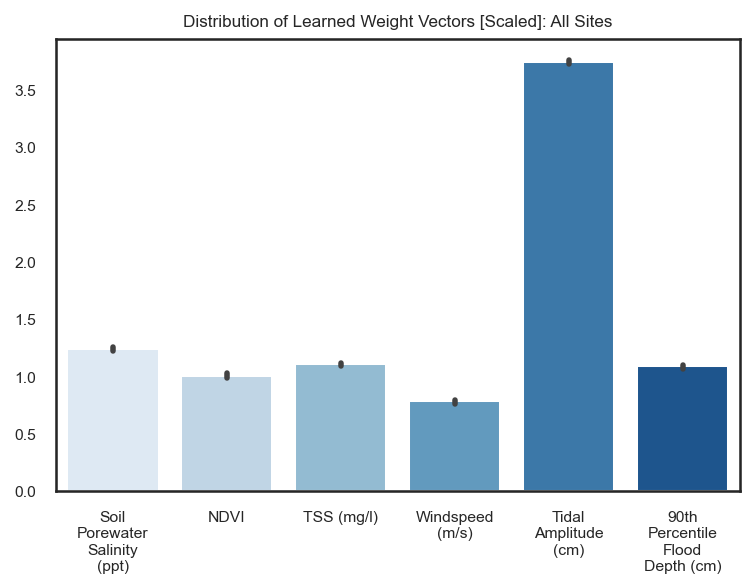

Soil Porewater Salinity (ppt)       1.240718
NDVI                                1.009273
TSS (mg/l)                          1.108916
Windspeed (m/s)                     0.783664
Tidal Amplitude (cm)                3.746626
90th Percentile Flood Depth (cm)    1.089814
dtype: float64

In [20]:
# Write a function for the visualization of plots: will wrap the labels of plots
def wrap_labels(ax, width, break_long_words=False):
    """ This function is only for the visualization of plots
    
    ax: plot axis object 
    width: width of textwrap
    break_long_words: boolean as to break long words in wrapping or not
    
    directly from: https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    """
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

    
# Lets plot the feature importances from the collected scaled weights
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Scaled]: All Sites')
sns.barplot(data=results_dict['Scaled Weights'], palette="Blues")
wrap_labels(ax, 10)
plt.show()

results_dict['Scaled Weights'].mean()

The bar chart above indicates the relative feature importances of the identified variables. We are able to achieve this feature importance through the absolute value of the weight coefficents for each input variable. This works because, prior to the fitting of the model, we scaled our weight coefficients to all lie within the the same range. Thus, we can interpret the magnitude of the weight coefficient learned from the scaled input features to be the relative importance of that feature.

Of the identified salient variables from the dataset related to vertical accretion, we see that tidal amplitude is the most important variable contributing to accretion in our linear model, while suspended sediment concetration is the least important variable contributing to accretion in the model. However, be sure to note that suspended sediment is still a significant variable defined by the backward elimination algorithm.

Something to consider here is the multicollinearity between the variables that is inherent to these environments. We must acknowledge that this potential bias may affect any future interpretations of the model. Additionally, the feature importances of each variable will vary depending on which type of model they are fit to. 

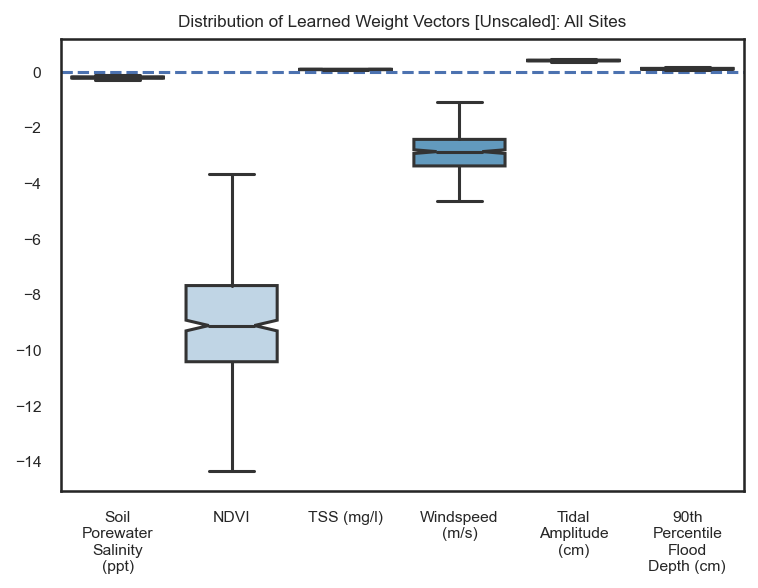

Soil Porewater Salinity (ppt)      -0.205421
NDVI                               -9.108063
TSS (mg/l)                          0.085083
Windspeed (m/s)                    -2.879328
Tidal Amplitude (cm)                0.407051
90th Percentile Flood Depth (cm)    0.110545
dtype: float64

In [21]:
# Plot the rescaled weight coefficients
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Unscaled]: All Sites')
ax.axhline(0, ls='--')
boxplot = sns.boxplot(data=results_dict['Unscaled Weights'], notch=True, showfliers=False, palette="Blues")
wrap_labels(ax, 10)
plt.show()

results_dict["Unscaled Weights"].mean()

The above plot is now the rescaled weight coefficents. They are represented through a boxplot because, since we run a 5-fold 100x repeated cross validation scheme, we train 500 models with slightly different learned weights because of varying splits of the data. Therefore, it is important to show the full range of the learned weights. We can intepret these as one would usually for any ordinary least squares regression such as "a one centimeter increase in tidal amplitude results in a ~0.41 mm/yr increase in the vertical accretion rate at a CRMS station."

These weight coeffiecents give us both the magnitude and direction of change. An increase in soil porewater salinity, NDVI, 90th percentile flood depth, and 10th percentile flood depth all negatively influence our models estimated accretion rate. While TSS, tidal amplitude, average percent time flooded, and flood depth all positively influence estimated deposition rates.

<a id='_SHAP'></a>
## SHAP Analysis

SHapley Additive exPlanations, SHAP, is a python package to explain how your model makes predictions after training. This is called *post hoc explainability* by Roscher et al 2020. The analysis that I present will show how to use some basic functions in the package to gather feature importance and feature dependence plots. However, there is a variety of other types of analysis one could do, depending on the model, that are described in the docs: https://shap.readthedocs.io/en/latest/

## SHAP on the Bayesian Ridge Regression

To get a basic understanding of what the Shapely values are and how to use them, I will give some explanations using the Bayesian Ridge, linear regression model. I do this because we already know how a linear regression model will approximate the output variable and can witness how shapely values are able to capture our expectations.

Shapely values are an explanation technique aquired from game theory that seek to quantify the involvement of players in a game. While this is an abstract notion, our use case defines the “players” as the features in the GPR model, and the “game” as the task of predicting vertical accretion rates. 

The direct computation of individual shapely values can be extremely computationally expensive. This is due to each individual shapely value quantifying the contribution of single sample of a single feature within a group of many features on the target variable. To do this, we include and exclude a feature from every possible set of the features that comprise the GPR model we defined. For instance, let this feature be the $j^{th}$ feature. We then randomly sample a value from each feature of the subset, compute the estimated outcome including the random sample of the $j^{th}$ feature, compute the estimated outcome excluding the $j^{th}$ feature, then subtract the two estimations from each other. The difference is the shapely value, making the shapely value the average contribution of a feature across all possible subsets of features. This can be thought of mathematically below (Molnar 2019, Štrumbelj and Kononenko 2014):
$$\phi_j=\frac{1}{M} \sum_{m=1}^{M} \hat{f}(x)_{-j}^m - \hat{f}(x)_{+j}^m$$
Equation 9

Where $\hat{f}(x)_{-j}^m$ is excluding the feature of interest, the $j^{th}$ feature, for the $m^th$ subset and $\hat{f}(x)_{+j}^m$ is including the feature of interest for the m^th subset. In our case the Shapely values will be in terms of influence on vertical accretion rate mm/yr. To overcome the computational expense of this process, an appropriate approximation method, such as a Monte-Carlo sampling method, is often employed to optimize the computation (Štrumbelj and Kononenko 2014).

Below, we show a bar plot of feature importances computed from shapely values. the importance scores are determined by averaging the absolute shapely values per feature across the data such that (Molnar 2019):

$$ Importance_j = \frac{1}{N} \sum_{n = 1}^{N} |\phi_j^n|$$
Equation 10

Where $Importance_i$ indicates the importance of the $j^{th}$ feature, $\phi_j^n$ indicates the shapely value of the $i^{th}$ sample of the $j^{th}$ feature, and $N$ indicates the total number of samples.

<class 'pandas.core.frame.DataFrame'>


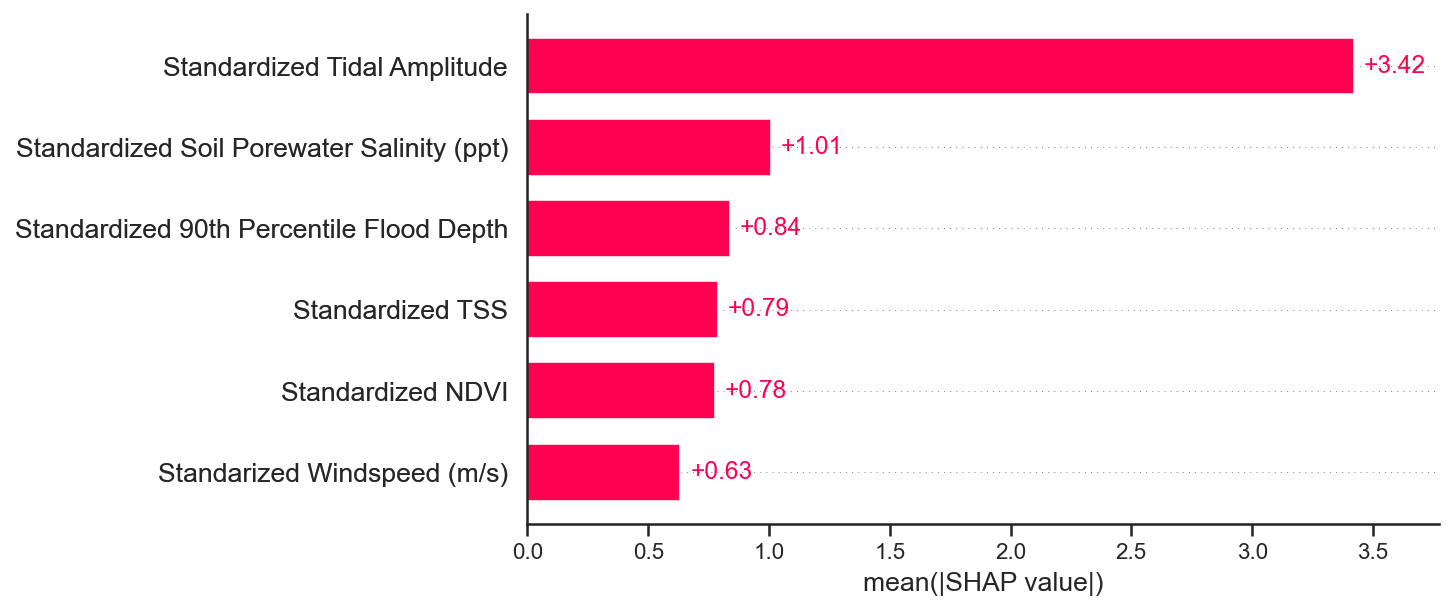

In [41]:
# Make a dataframe specifically for shap
shap_df = data[bestfeatures]
# include "standardized" in the feature names to make it clear that these features are standardized/scaled
shap_df = shap_df.rename(columns={'Tidal Amplitude (cm)': 'Standardized Tidal Amplitude',
                                 'Avg. Flood Depth (cm)':'Standardized Avg. Flood Depth',
                                 '90th Percentile Flood Depth (cm)': 'Standardized 90th Percentile Flood Depth',
                                 'Soil Porewater Salinity (ppt)': 'Standardized Soil Porewater Salinity (ppt)', 
                                 'NDVI': 'Standardized NDVI', 
                                 'TSS (mg/l)': 'Standardized TSS', 
                                 'Avg. Time Flooded (%)': 'Standardized Avg. Time Flooded',
                                 '10th Percentile Flood Depth (cm)': 'Standardized 10th Percentile Flood Depth',
                                 'Windspeed (m/s)': 'Standarized Windspeed (m/s)'}
                        )

# fit the model first
br.fit(shap_df, target)
# Shap Analysis
X500 = shap.utils.sample(shap_df, 500) # randomly sample 100 instances for use as the background distribution
print(type(X500))
explainer_ebm = shap.Explainer(br.predict, X500)  # explain a random sample of the data
# explainer = shap.Explainer(gp)
shap_values_ebm = explainer_ebm(X500)

shap.plots.bar(shap_values_ebm)

We see that the feature importances computed by the SHAP values are almost the same as our computed feature importances values using only the mean of the learned weight vectors, given scaled predictor variables. 

We can visualize a more informative representation of the feature importances using the summary plot method from SHAP. This plot gives us the order of feature importances, the distribution of shapely values, and an idea of the direction of influence each feature has on the outcome. Similar to the above bar plot, the feature importances are in descending order. From where the points are located horizontally, to the right or left of the SHAP value equals 0 (x-axis), we can determine whether that points holds positive or negative influence on the outcome. If the distribution of the shapely values widens, this means more shapely values lie in that range. Depending on whether the widening lies to the left or right of the $0$ on the x-axis, we can determine whether the majority of samples hold a positive or negative influence on accretion. The colorbar on the right of plot indicates the specific feature's importance value for that given sample. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


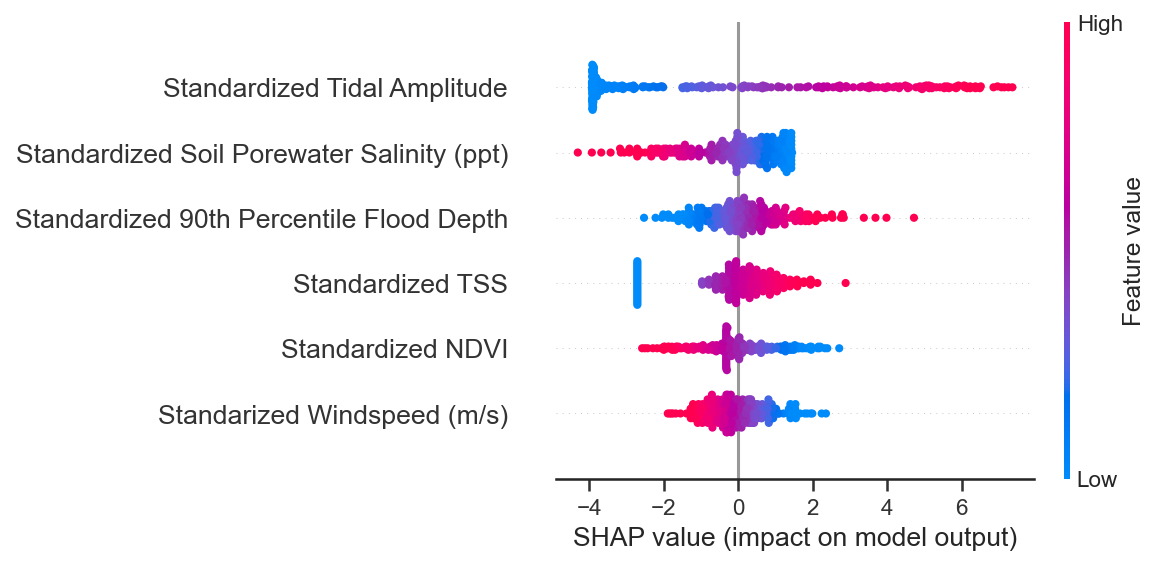

In [42]:
shap.summary_plot(shap_values_ebm, features=shap_df, feature_names=shap_df.columns.values)

Examining the three most important features in the summary plot, we see that tidal amplitude has a net positive affect on the outcome as indicated by the red colorbar, while a substantial amount of the samples in the distribution are contributing negatively to accretion rate. Average flood depth also has a net positive effect on vertical accretion rate, while, again, much of the samples contribute negatively to vertical accretion rate. Opposite to tidal amplitude and average flood depth, soil porewater salinity contributes negatively to vertical accretion rate, while much of the samples actually contribute positively!

Another way to interpret how certain features and samples are influencing our predicted vertical accretion rates is through a *heatmap* plot. The heatmap highlights how each sample influences certain predictions. On the upper x-axis (top of plot) we see how the outcome, $f(x)$, varies given different samples. For this particular plot, I have arranged the instances so that the expected vertical accretion values is decreasing from left to right. In our case, $f(x)$ is vertical accretion rate. The red segments indicate a positive shapely value for the feature corresponding horizonally, indicating that the feature positively influences the expected vertical accretion rate. While the blue segments indicate negative shapely values, indicating that the corresponding feature negatively influences the expected vertical accretion rate.

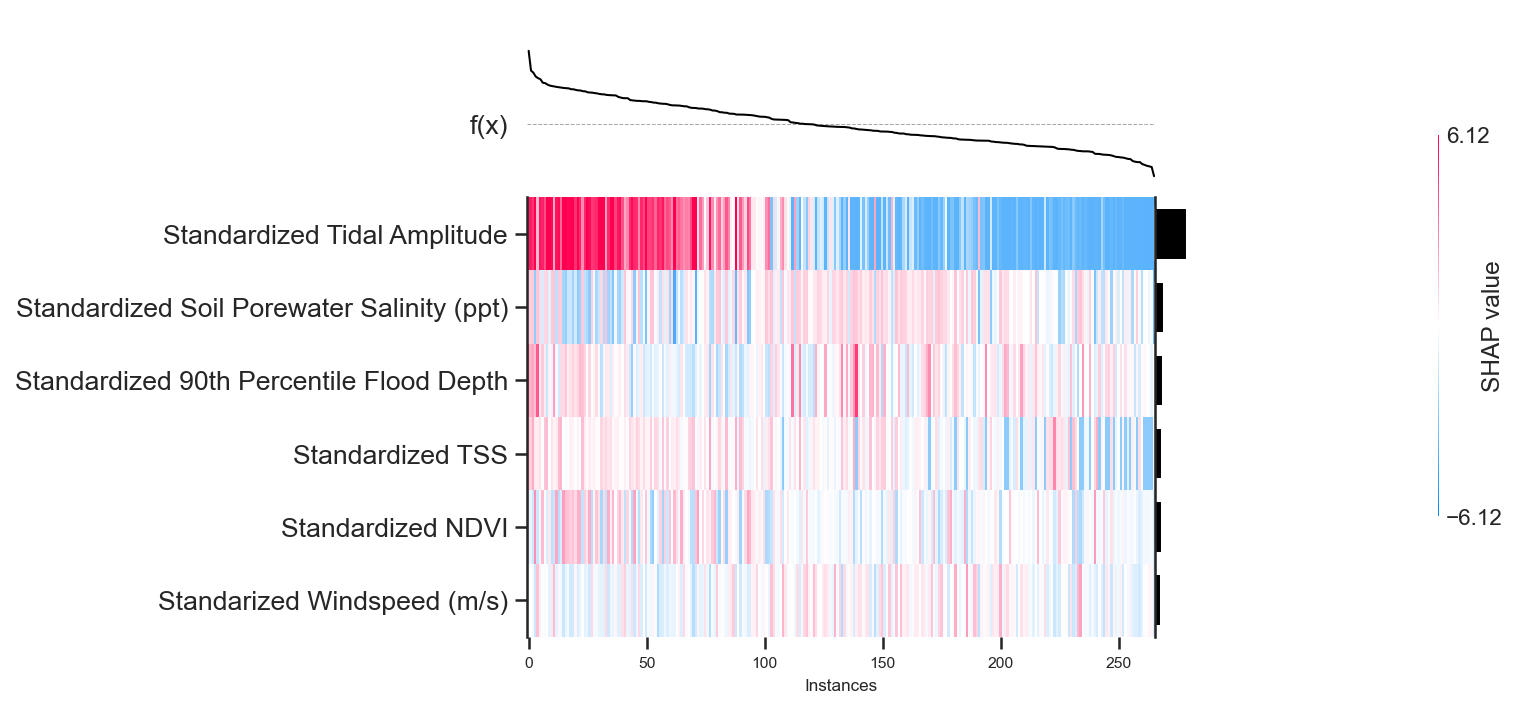

In [43]:
# A summary of the sample scale predictions
shap.plots.heatmap(shap_values_ebm, instance_order=shap_values_ebm.sum(1))

Through the heatmap, we see that tidal amplitude is largely the determinant variable for predicted accretion rates. Most of tidal amplitude's positive shapely values lie to the left of the plot, where $f(x)$ is positive, while most of the negative shapely values lie to teh right where $f(x)$ is negative.


## Partial Dependence Plots and SHAP Dependence Plots

Partial dependence plots are show the marginal effect of a feature and the resultant outcome variable given our model (Molnar 2019), helping us get an idea of the type of relatinship the two variables have together. Given that we are looking at the partial dependence plots within a linear regression, we will expect to see only linear relationships in these plots between outcome and feature. 

The SHAP dependence plots are similar to the partial dependence plots, but slightly different. Rather than the expected outcome on the y-axis, the shapely value is represented. While the partial dependence plot will roughly approximate the trends of the SHAP dependence plots. 

Let us examine the partial dependence plots for the 3 main contributors to accretion. 

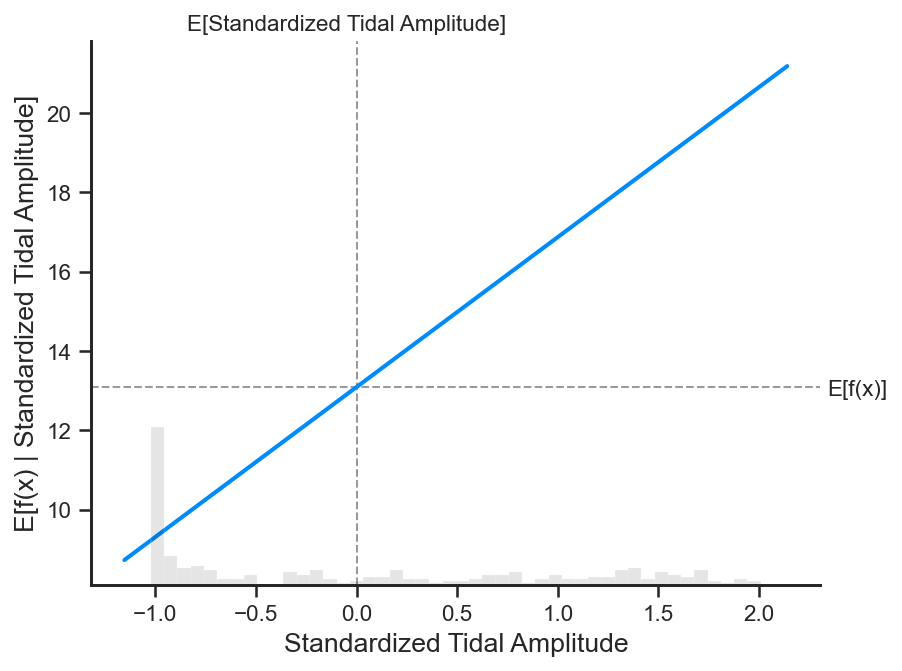

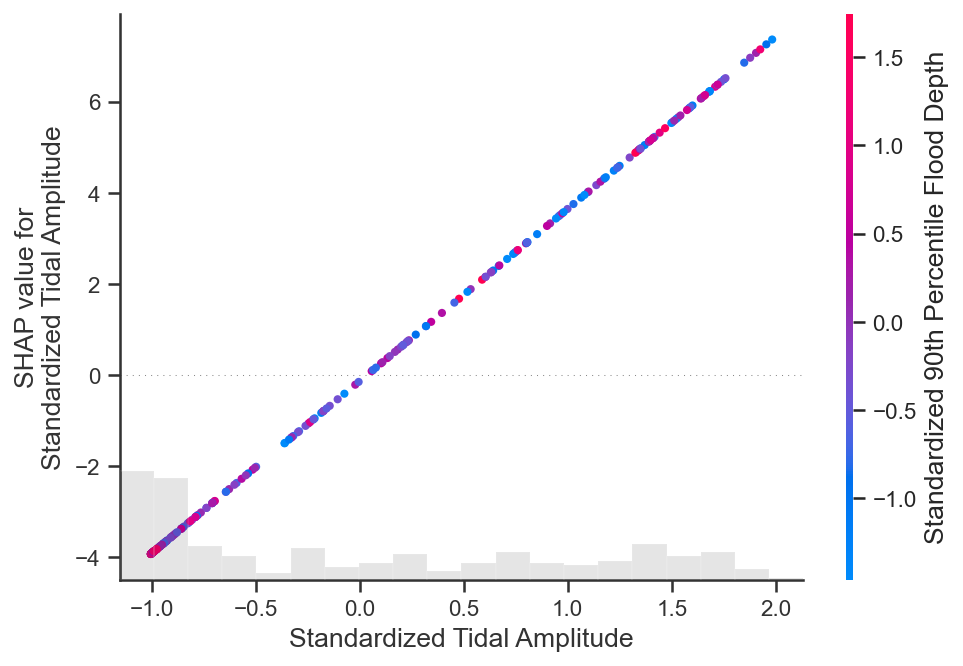

In [44]:
shap.partial_dependence_plot(
    'Standardized Tidal Amplitude', br.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "Standardized Tidal Amplitude"],
                   color=shap_values_ebm[:,"Standardized 90th Percentile Flood Depth"])

Tidal amplitude has a clear positive relationship with the expected vertical accretion outcome as depicted by the partial dependence plot. The SHAP dependence plots displays a similar story, while the samples are colored by the normalized average flood depth value. However, there is no clear relationship between certain average flood depth values and increasing or decreasing expected outcomes.

Next we are going to investigate the average flood depth, the second most important variable in our BLR model. But, we must also take a lot at the 90th percentile of the flood depth along with the average flood depth because the two are inherently intertwined. As flood depth increases, we expect the 90th percentile of the flood depth to increase as well. The below scatter plot reinforces this notion.

We can vaguely see the different signitures of the influence of the 90th percentile flood depth at varying tidal amplitudes in the above scatter plot. For the same 90th percentile flood depth of, for example 40 cm, there is significantly less vertical accretion at a tidal amplitude of 0 cm versus at a tidal amplitude of 25 cm. This is what our model is picking up as shown by the SHAP dependence plot.

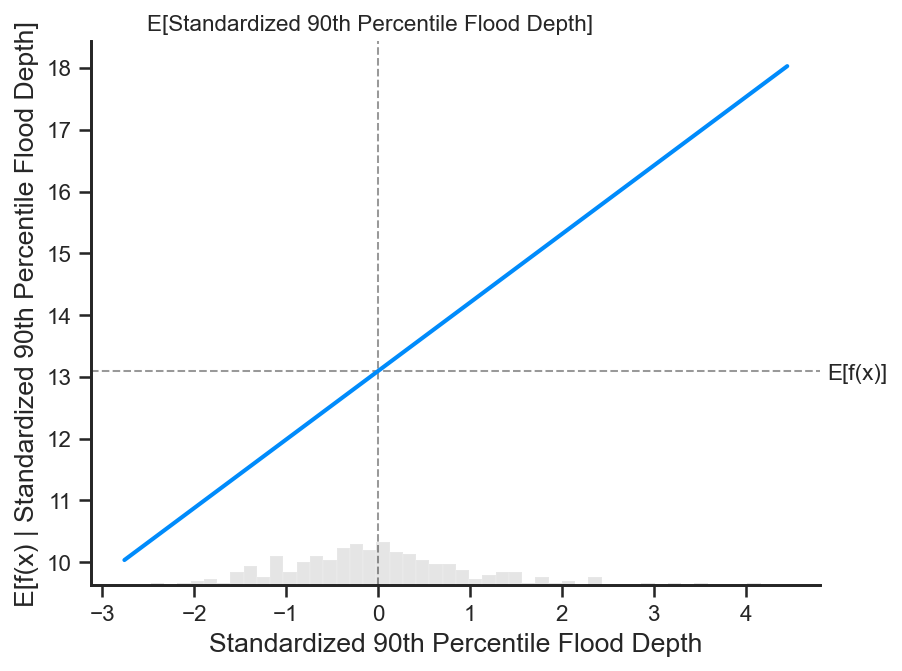

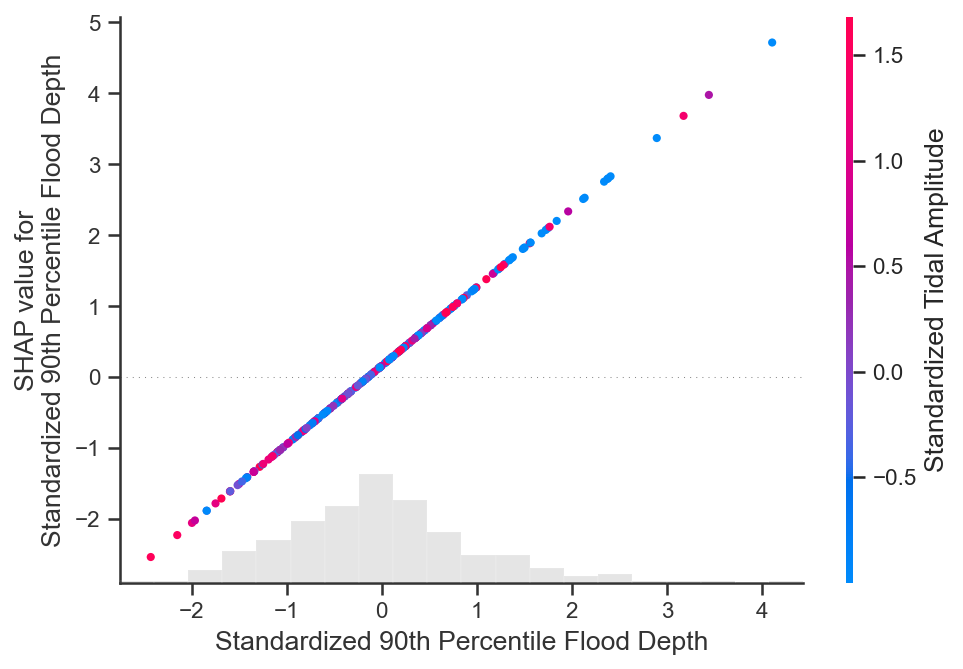

In [45]:
# Let us look at the partial dependence plot for Avgerage flood depth
shap.partial_dependence_plot(
    "Standardized 90th Percentile Flood Depth", br.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the SHAP dependence plot for average flood depth
shap.plots.scatter(shap_values_ebm[:, "Standardized 90th Percentile Flood Depth"],
                   color=shap_values_ebm[:,"Standardized Tidal Amplitude"])

<a id='_GPR'></a>
# Applying a Nonlinear Model

## Gaussian Process Regression

The GPR begins with our desire to find an unknown function $f(x)$ that will help us predict our target variable $y$ with the addition of some Gaussian distributed noise, $\epsilon$, such that:
$$ y = f(x)+ \epsilon $$
Equation 11

The BLR approach falls short when the relationship between our input and output variables is nonlinear, due to defining our unknown function as a linear combination of the predictors governed by the learned weight parameter, $w$. A Gaussian Process Regression (GPR) overcomes the limited flexibility of the BLR by projecting the inputs into an infinitely high dimensional space using a set of basis functions which allow us to overcome the assumption of linearity in a BLR (Rasmussen and Williams 2005). This makes GPR a powerful non-parametric machine learning tool that can capture the nonlinear dynamics and interactions of the input and output variables. 

The reasoning behind a GPR includes using a Gaussian Process to describe the distribution over all possible functions for a given sample $x_i$. Defined as a collection of random variables of which any finite set have a joint Gaussian distribution, a Gaussian process can be completely specified by its mean function, $m(x)$, and covariance function, $k(x,x')$ (Rasmussen and Williams 2005). Following Rasmussen and Williams 2005, with a known mean and covariance, we can write the prior distribution of all possible random unknown functions as:
$$ f(x)∼GP(m(x),k(x,x')) $$
Equation 12

An important choice for the investigator is choosing the covariance function, $k(⋅,⋅)$, for the GPR model that best describes our data. In broad sense, we expect similar samples to have similar outcomes and effects on the target variable and the covariance function is what defines the similarity between samples. After multiple trials, we deduce that a squared dot product covariance function fits our data best.  
$$ k(x,x' )=(x \cdot x' )^2+\delta$$
Equation 13

Where $\delta$ is the error associated with the target variable and $x$ and $x'$ are predictors.  

From a specified mean and covariance function, the computation of the conditional probability of our target is straight forward. Assuming a zero mean we can write:

$$\begin{bmatrix} y \\ f_* \end{bmatrix} = \mathcal{N} ( \begin{bmatrix} 0 \\ 0 \end{bmatrix} , \begin{bmatrix} (k(X,X)+σ^2I & k(X,X_*) \\ k(X_*,X) & k(X_*,X_*) \end{bmatrix} )$$
Equation 14

Where $k(X,X)$ is the covariance between training samples, $k(X_*,X_*)$ is the covariance between testing samples, $k(X_*,X)$ and $k(X,X_*)$ are the covariances between training and testing samples, $y$ is the target variable, $f_*$ is the learned function, and $\sigma^2$ is the noise associated with the target variable (Rasmussen and Williams 2005). Utilizing the rules for the combination of partitioned Gaussians we can write the mean and covariance for the predictive distribution as
$$ m(x)=k(X_*,X)(k(X,X)+ σ^2 I)^{-1} y $$
Equation 15

$$ k(x,x') = k(X_*,X_* ) - k(X_*, X)(k(X,X)+ σ^2 I)^{-1} k(X,X_*) $$
Equation 16


In [46]:
# Load packages relevant for the gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, WhiteKernel, Matern, Sum

# GP model 
gp = GaussianProcessRegressor(kernel=(DotProduct()**2) + WhiteKernel(),
                              n_restarts_optimizer=10, alpha=1, normalize_y=False, random_state=123)

rcv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=123)
scores = cross_validate(gp, shap_df, target, cv=rcv, 
                        scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
print("Median GP R^2 score", np.median(scores['test_r2']))
print("Median GP MAE score", abs(np.median(scores['test_neg_mean_absolute_error'])))

Median GP R^2 score 0.43936522408587403
Median GP MAE score 3.635438434459999


Great, we increase r-squared by about 10%!


<a id='_SHAPGPR'></a>
## SHAP Analysis for Gaussian Process Regression

To visualize the nonlinear dynamics captured by the Gaussian Process Regression, we will implement the same SHAP analysis as we did for the Bayeisan Linear Regression. Notice that the form kernel function will largely dictate the type of functions that will be represented between the features and vertical accretion rate. 

<class 'pandas.core.frame.DataFrame'>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


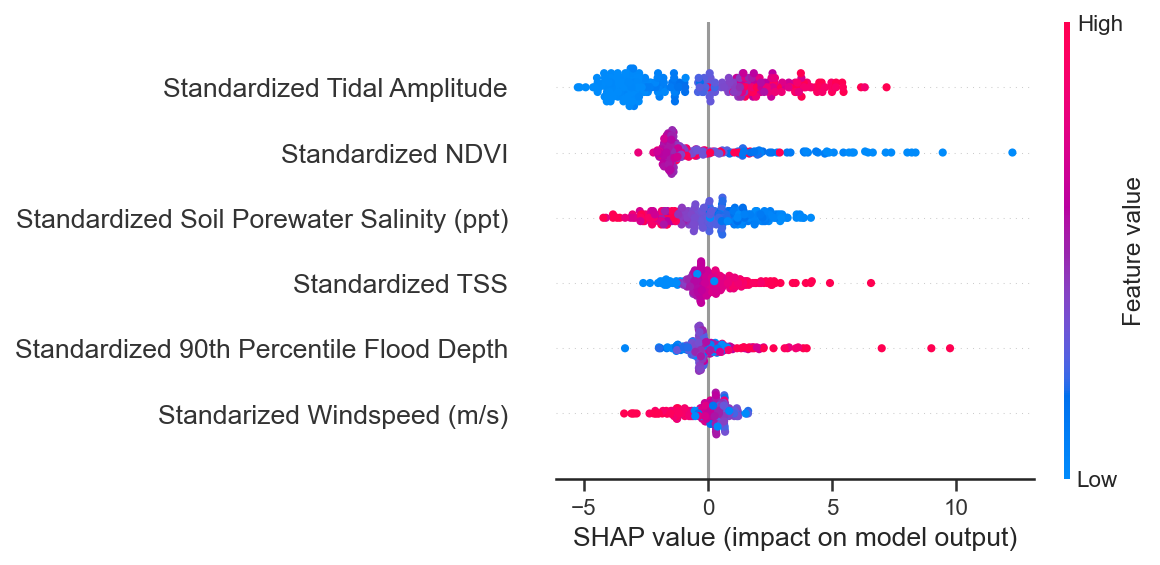

In [47]:
# fit the model first
gp.fit(shap_df, target)
# Shap Analysis
X500 = shap.utils.sample(shap_df, 500) # randomly sample 100 instances for use as the background distribution
print(type(X500))
explainer_ebm = shap.Explainer(gp.predict, X500)  # explain a random sample of the data
# explainer = shap.Explainer(gp)
shap_values_ebm = explainer_ebm(shap_df)

shap.summary_plot(shap_values_ebm, features=shap_df, feature_names=shap_df.columns.values)

While average flood depth and tidal amplitude are still identified as the most important variables, the importance of the other variables changes slightly in the GPR model. Let's look at the heatmap summary plot to get a better idea of how these variables influence different accretion rates.

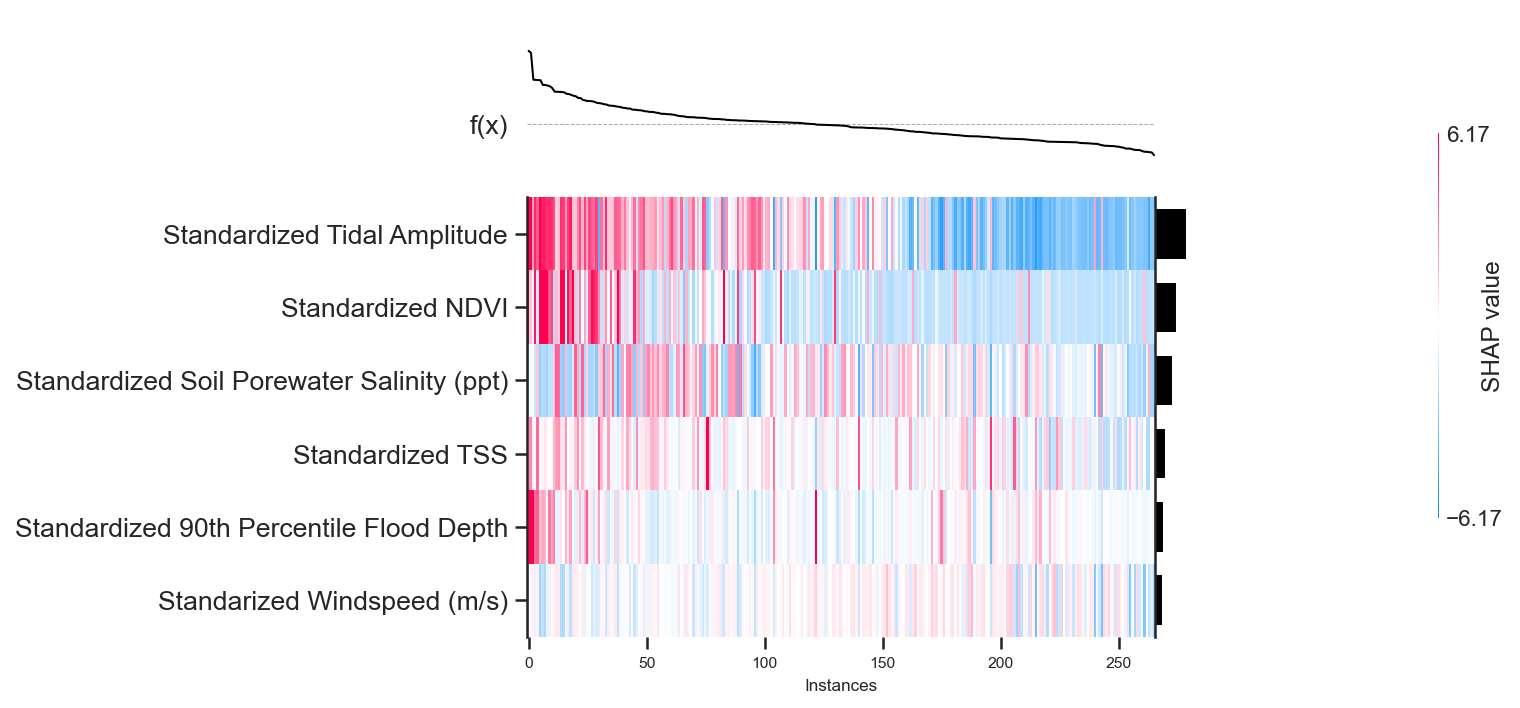

In [48]:
# A summary of the sample scale predictions
shap.plots.heatmap(shap_values_ebm, instance_order=shap_values_ebm.sum(1))

Similar trends as in the BLR are picked up, except there is definetly less of a relience on tidal amplitude for making vertical accretion rate predictions. We also see that the higher estaimtes of vertical accretion rates are largely positively influenced by tidal amplitude, NDVI, and the 90th percentile of flood depth. While the lowest estaimtes of vertical accretion are largely negatively influenced by tidal amplitude and NDVI, but rely little upon the 90th percentile of flood depth. 

Let's again look at some partial dependence and SHAP dependence plots to see how the GPR differs from the BLR.

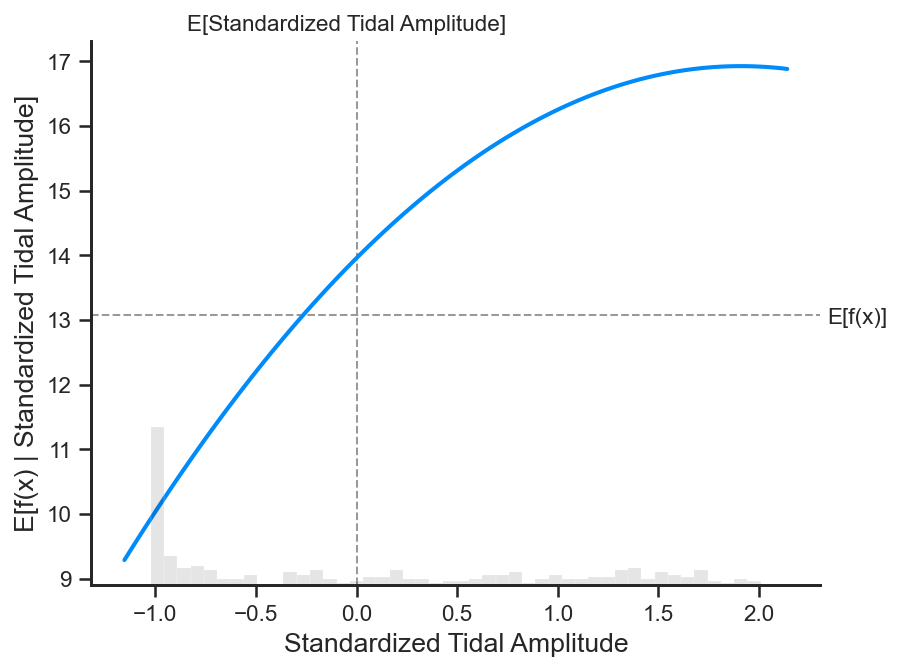

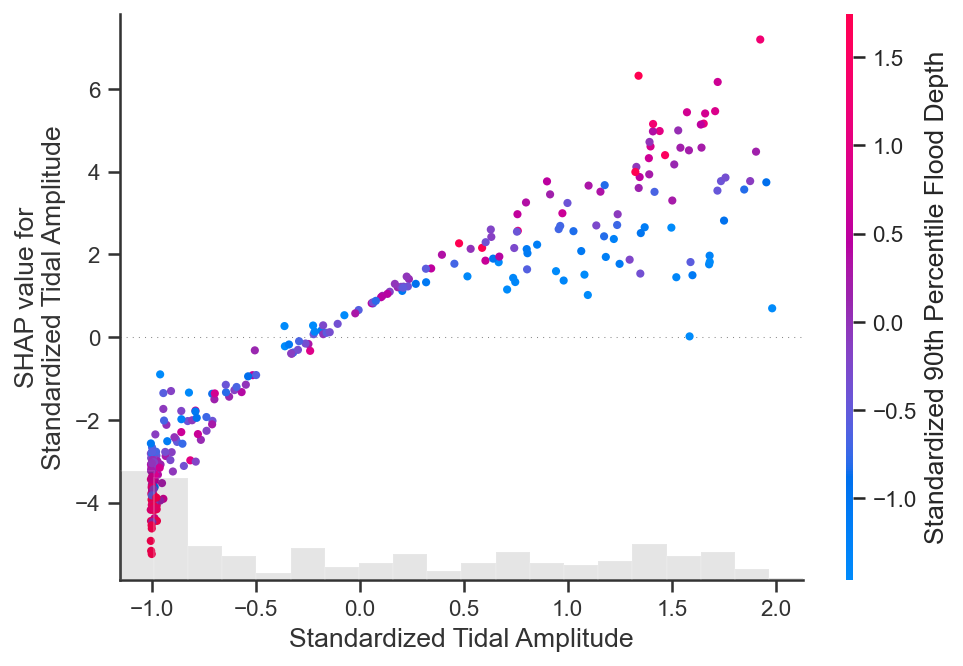

In [49]:
# Plot the partial dependence of the tidal amplitude within the GPR
shap.partial_dependence_plot(
    'Standardized Tidal Amplitude', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot of tidal amplitude within the GPR, colored by average flood depth
shap.plots.scatter(shap_values_ebm[:, "Standardized Tidal Amplitude"],
                   color=shap_values_ebm[:,"Standardized 90th Percentile Flood Depth"])

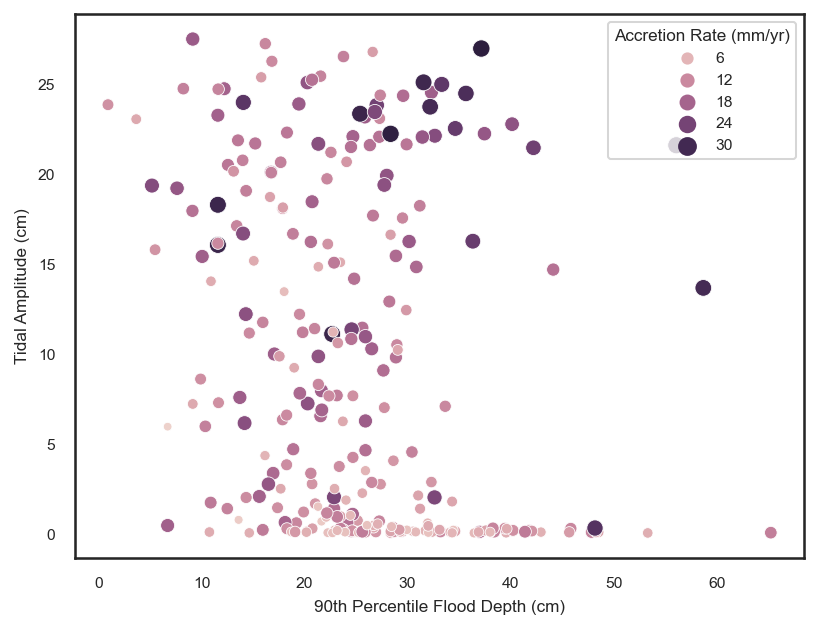

In [50]:
sns.scatterplot(data=df, x='90th Percentile Flood Depth (cm)', y='Tidal Amplitude (cm)', hue='Accretion Rate (mm/yr)',
               size='Accretion Rate (mm/yr)')
plt.show()

Nice! We get a similar trend as in the partial dependence plot for the BLR, but, this time, there is a little curvature to the partial dependence function. This indicates that the trend between tidal amplitude and accretion is truly captured with a linear relationship. We see a slight nonlinearity to this form, but its significance might be largely minimal. 

The zero in the x-axis indicates that mean of the tidal amplitude data distribution, while each unit is in standard deviations. We notice that across the mean of the tidal amplitude data, standard deviation equal 0.0, flood depths have a opposite association with tidal amplitude and accretion rate. Where tidal amplitudes are below the mean, flood depth decreases with increasing tidal amplitude, while the expected accretion rate increases. Where tidal amplitudes are above the mean, flood depths increase with increasing tidal amplitude, while the expected accretion rate also increases.

With tidal amplitude increasing with flood depth above the mean tidal amplitude, we may expect this to be due to a greater influence of oceanic flood waters on flooding. To test qualitatively test this, we can look at the relationship between tidal amplitude, flood depth, and soil porewater salinity, assuming that an increase in the soil porewater salinity is associated with a more saline flooding regime.

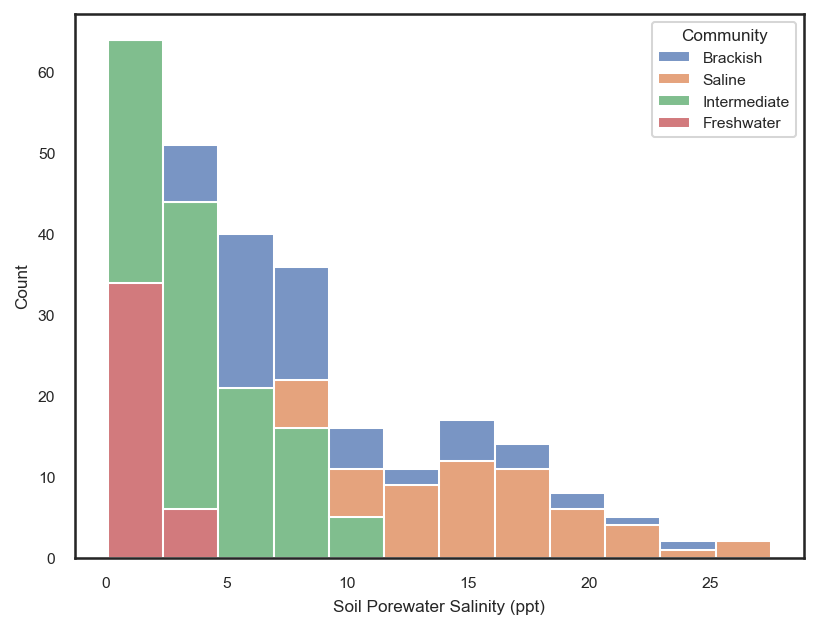

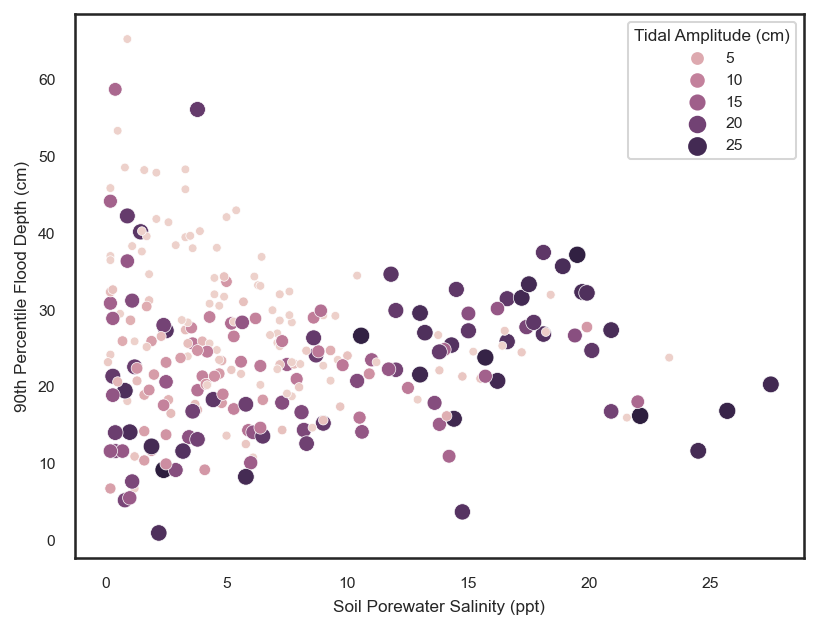

In [51]:
# Histogram to see splits in salinity distributions across marsh types
sns.histplot(data=df, x='Soil Porewater Salinity (ppt)', hue='Community', multiple='stack')
plt.show()
# scatter
sns.scatterplot(data=df, x='Soil Porewater Salinity (ppt)', y='90th Percentile Flood Depth (cm)', hue='Tidal Amplitude (cm)',
               size='Tidal Amplitude (cm)')
plt.show()

The stacked histogram shows us that the distribution of salinity values in the saline marsh sites deviate from the fresher water sites around a value of ~10 ppt. By examining the subsequent scatter plot, we see that above salinity values of ~10 ppt, in the saline marshes, there is a positive trend between salinity and flood depth. While, for salinity values less than ~10 ppt, there is no relationship to a weak logarithmic relationship between flood depth and salinity. This could be potentially highlighting the difference in flooding regimes between the saline sites and the fresher water sites. Great! We have justed used a post-training machine learning explanation technique to find a relationship that we may not have noticed before!

Now let's take a look at both the avearge flood depth and the 90th percentile of the flood depth

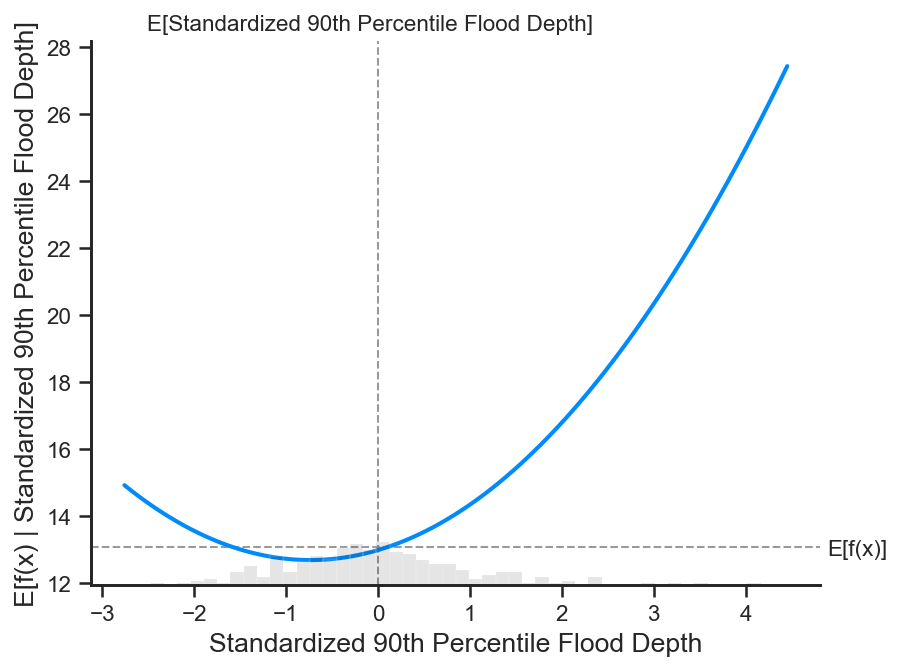

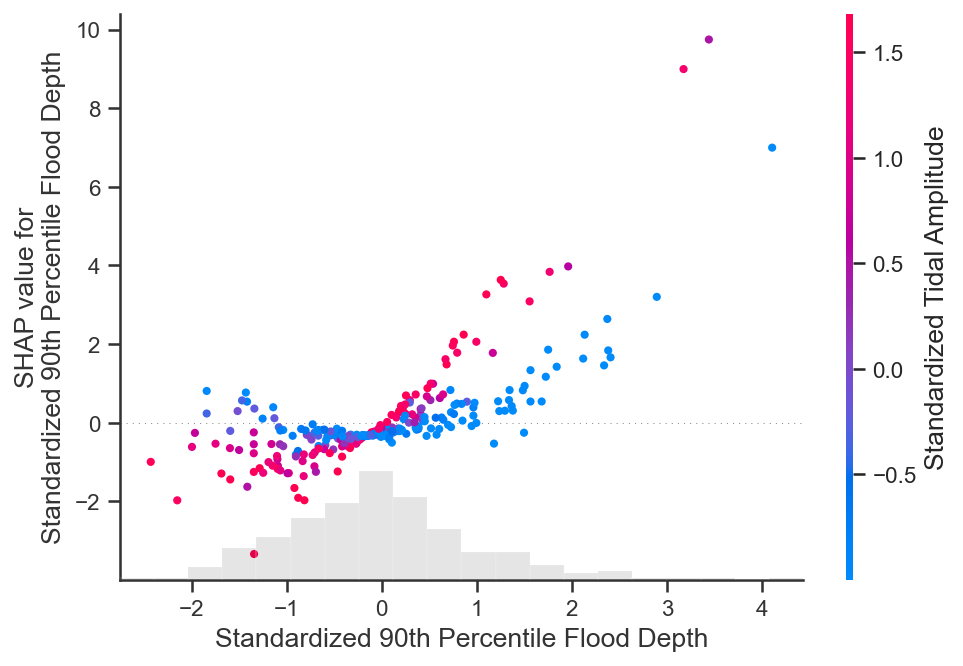

In [52]:
# partial dependence plot for 90th percentile flood depth
shap.partial_dependence_plot(
    'Standardized 90th Percentile Flood Depth', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Now lets look at the dependence plot with interactions
shap.plots.scatter(shap_values_ebm[:, "Standardized 90th Percentile Flood Depth"], 
                   color=shap_values_ebm[:,"Standardized Tidal Amplitude"])

Again, we see the varying influences of the 90th percentile flood depth at differnt tidal amplitudes. A clear split in the SHAP dependence functions is present beetween low and high tidal amplitude values. 

Using machine learning techniques not only provides opportunities for increasing the accuracy of forecasts, but also augments our ability to better understand the phenomena we are trying to model through exaplainable AI. The workflow promoted in this tutorial can be generalized to any earth science application with a small dataset and the goal of obtaining a process based understanding of the influences of the features on the outcome variable. 

We hope that this tutorial was useful for any 

# Sources

Allen, George H., and Tamlin M. Pavelsky. “Global Extent of Rivers and Streams.” Science 361, no. 6402 (August 10, 2018): 585–88. https://doi.org/10.1126/science.aat0636.

Atlas, Global Wind. "Global Wind Atlas 3.0, a free, web-based application developed, owned and operated by the Technical University of Denmark (DTU)." The Global Wind Atlas 3 (2022).

Bishop, Christopher M. Pattern Recognition and Machine Learning. Information Science and Statistics. New York: Springer, 2006.

Molnar, C. (2019). Interpretable machine learning: A guide for making black box models explainable.

Rasmussen, Carl Edward, and Christopher K. I. Williams. Gaussian Processes for Machine Learning. The MIT Press, 2005. https://doi.org/10.7551/mitpress/3206.001.0001.

Silva, Sam J., Christoph A. Keller, and Joseph Hardin. “Using an Explainable Machine Learning Approach to Characterize Earth System Model Errors: Application of SHAP Analysis to Modeling Lightning Flash Occurrence.” Journal of Advances in Modeling Earth Systems 14, no. 4 (April 2022). https://doi.org/10.1029/2021MS002881.

Wager, R.T., & E.L. Haywood III, (2022). State of Louisiana Coastal Protection and Restoration Authority (CPRA) Coastal Information Management System (CIMS) Data Dictionary. Version 1.0, pp. 1-133.
